### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [1]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

#physical_devices = tf.config.experimental.list_physical_devices()
#tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x0000013CA98440D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 12: NN conversion to TFLite (quantization)

Most of the notebook was based on the *10_ESR_data_preparation.ipynb*. The differences are the neural network conversion (quantization) as preparation to embeeded them in the Raspberry Pi.

***

## Import modules

In [2]:
import os
import warnings
import mimetypes
import time
import pickle

import pandas     as pd
import seaborn    as sns
import numpy      as np

import IPython.display as ipd

from matplotlib  import pyplot  as plt

from collections                 import Counter
from sklearn                     import metrics
from sklearn.ensemble            import RandomForestClassifier
from sklearn.metrics             import classification_report
from tensorflow.keras.models     import load_model

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 9)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

mimetypes.init()
mimetypes.add_type('audio/ogg','.ogg')

In [3]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '12_NN_conversion_quantization_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

cmap_cm     = plt.cm.Blues

tf.random.set_seed(SEED)
np.random.seed(SEED)

## Data preparation

In [4]:
cmap_cm     = plt.cm.Blues

path        = os.path.join(current_path, "_dataset", "US8K_AV")
path_models = os.path.join(current_path, "US8K_AV_saved_models")
path_pic    = os.path.join(current_path, "US8K_AV_results")

path_modelsVal = os.path.join(current_path, "_ESR", "Saved_models_fold_1_validation")
path_arrays    = os.path.join(current_path, "_ESR", "Arrays")

# Check if the folder exists, if not, create it
if not os.path.exists(path_models):
    os.makedirs(path_models)

if not os.path.exists(path_arrays):
    os.makedirs(path_arrays)

nom_dataset               = 'US8K_AV' 
csv_file                  = 'US8K_AV.csv'
fold_name                 = '1'

pkl_features              = 'US8K_AV_features_original.pkl'
pkl_aug_wind_features     = 'US8K_AV_features_windowed.pkl' # not augmented, just windowed
pkl_aug_features          = 'US8K_AV_features_augmented_no_windowing.pkl'

pkl_aug_wind_features_CNN = 'US8K_AV_features_CNN_2D_windowed.pkl' # not augmented, just windowed

DB_ori_from_pkl       = pd.read_pickle(os.path.join(path_models, pkl_features))
DB_aug_from_pkl       = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features))
DB_aug_CNN2D_from_pkl = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features_CNN))

In [5]:
print(type(DB_ori_from_pkl['Fold'][0][0]))
print(type(DB_aug_from_pkl['Fold'][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0][0]))
print(type(DB_ori_from_pkl['Class_OHEV'][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [6]:
for fold in np.unique(DB_ori_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold])
    trnsize = len(DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 478
dbComplete size: 4430

Validation fold: 10
dbComplete_VAL size: 468
dbComplete size: 4440

Validation fold: 2
dbComplete_VAL size: 485
dbComplete size: 4423

Validation fold: 3
dbComplete_VAL size: 536
dbComplete size: 4372

Validation fold: 4
dbComplete_VAL size: 599
dbComplete size: 4309

Validation fold: 5
dbComplete_VAL size: 529
dbComplete size: 4379

Validation fold: 6
dbComplete_VAL size: 460
dbComplete size: 4448

Validation fold: 7
dbComplete_VAL size: 465
dbComplete size: 4443

Validation fold: 8
dbComplete_VAL size: 441
dbComplete size: 4467

Validation fold: 9
dbComplete_VAL size: 447
dbComplete size: 4461



In [7]:
print(type(DB_aug_CNN2D_from_pkl['Fold'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Fold'][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0][0]))
print(type(DB_aug_CNN2D_from_pkl['Class_OHEV'][0]))

<class 'str'>
<class 'str'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>
<class 'numpy.int32'>
<class 'numpy.ndarray'>


In [8]:
DB_ori_from_pkl

,Audio,Class_categorical,Class_OHEV,Fold,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
0,"[-0.0034710653, -0.0050192624, -0.004654482, -0.0049833283, -0.0038681468, -0.0023575649, -0.00025486574, 0.00135406...",dog_bark,"[0, 0, 0, 1, 0, 0]",5,...,0.024244,-0.049756,0.759231,-0.024962
1,"[0.0027405696, 0.0036386526, 0.0023064336, 0.0023546093, 0.0025339962, 0.0030277965, 0.0027998006, 0.0028241847, 0.0...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018670,-0.018241,0.275013,-0.497943
2,"[-0.0027212622, -0.0030217567, -0.0016039186, -0.0012952066, -0.001044448, -0.0011087725, -0.0006573542, -0.00120615...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.018733,0.009139,-0.205466,-0.212879
3,"[0.00015050662, -0.00023231667, -0.0013628466, -0.002236663, -0.0027237535, -0.002267104, -0.0012131947, -0.00148792...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.027117,0.007208,-0.769827,0.623153
4,"[0.0012501464, 0.00428795, 0.0062407875, 0.0055125337, 0.003776363, 0.0018791268, 0.0014532767, 0.0026125484, 0.0038...",children_playing,"[0, 0, 1, 0, 0, 0]",5,...,0.025776,0.050245,0.208739,-1.062755
...,...,...,...,...,...,...,...,...,...
4903,"[0.0020684754, 0.002996013, 0.0027406309, 0.0031264792, 0.0030979805, 0.0032640784, 0.0030700786, 0.0029712087, 0.00...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.046910,-0.014152,1.014088,0.288518
4904,"[-0.00054763607, -0.0006439837, -0.0003565054, -0.00026786933, -0.00012919167, -0.0002218535, -0.00025803095, -0.000...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.048725,0.003801,-0.290986,-1.009455
4905,"[0.00036112632, 0.0003222265, -2.3932662e-05, -0.00028421593, -0.0005354925, -0.0005733533, -0.00046778092, -0.00020...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.032608,-0.043836,1.350900,2.272794
4906,"[-0.0002325126, -0.00035913184, -0.00025248923, -0.0001690893, 1.3734563e-05, 0.00021053397, 0.0003744613, 0.0003582...",silence,"[0, 0, 0, 0, 1, 0]",9,...,0.026508,-0.003402,-0.001074,-0.871445


In [9]:
DB_aug_CNN2D_from_pkl

,Class_categorical,Class_OHEV,Fold,features
0,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4..."
1,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-..."
2,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3..."
3,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39...."
4,dog_bark,"[0, 0, 0, 1, 0, 0]",5,"[[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [..."
...,...,...,...,...
34351,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-28.725196838378906], [-21.75506591796875], [-15.691794395446777], [-11.686802864074707], [-13.252153396606445], ..."
34352,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-18.317378997802734], [-14.795974731445312], [-13.88856315612793], [-13.34511947631836], [-14.05569076538086], [-..."
34353,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-14.710319519042969], [-12.146648406982422], [-13.191940307617188], [-14.210320472717285], [-15.148565292358398],..."
34354,silence,"[0, 0, 0, 0, 1, 0]",9,"[[[-26.25575828552246], [-20.983177185058594], [-14.533549308776855], [-15.130903244018555], [-16.879596710205078], ..."


In [10]:
for fold in np.unique(DB_aug_CNN2D_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] == fold])
    trnsize = len(DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 3346
dbComplete size: 31010

Validation fold: 10
dbComplete_VAL size: 3276
dbComplete size: 31080

Validation fold: 2
dbComplete_VAL size: 3395
dbComplete size: 30961

Validation fold: 3
dbComplete_VAL size: 3752
dbComplete size: 30604

Validation fold: 4
dbComplete_VAL size: 4193
dbComplete size: 30163

Validation fold: 5
dbComplete_VAL size: 3703
dbComplete size: 30653

Validation fold: 6
dbComplete_VAL size: 3220
dbComplete size: 31136

Validation fold: 7
dbComplete_VAL size: 3255
dbComplete size: 31101

Validation fold: 8
dbComplete_VAL size: 3087
dbComplete size: 31269

Validation fold: 9
dbComplete_VAL size: 3129
dbComplete size: 31227



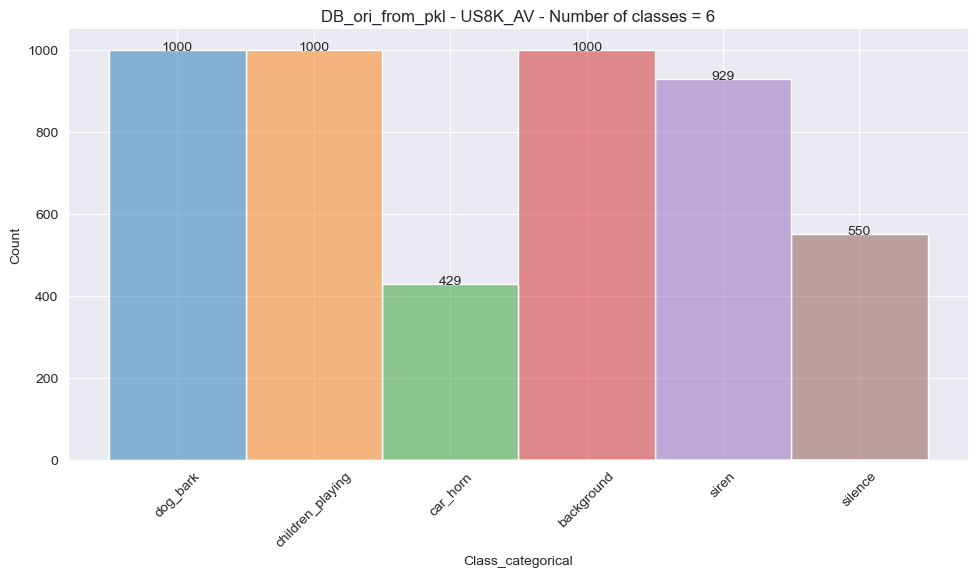

In [11]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_ori_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_ori_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_ori_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

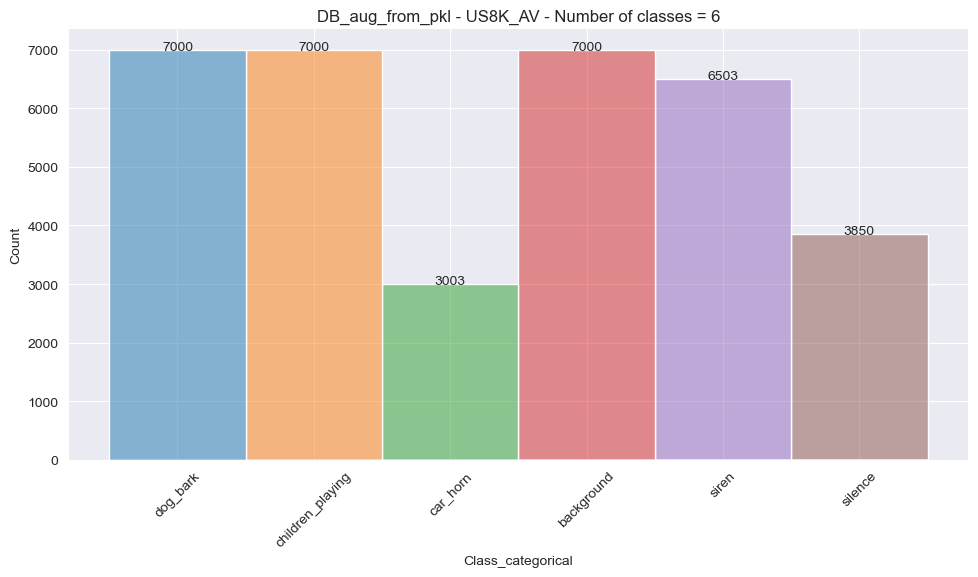

In [12]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

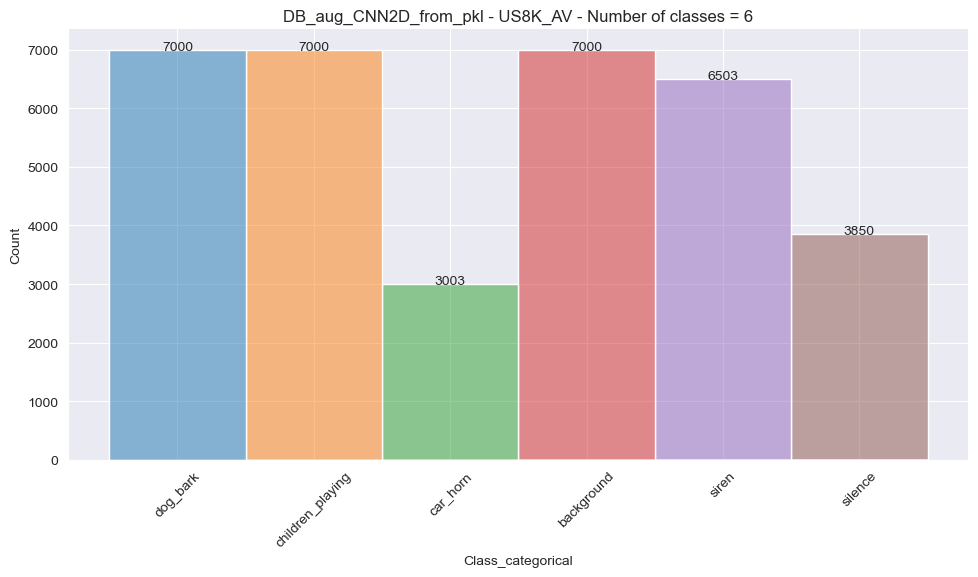

In [13]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = 'DB_aug_CNN2D_from_pkl - ' + nom_dataset + ' - Number of classes = ' + str(len(pd.Series(DB_aug_CNN2D_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_aug_CNN2D_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=45)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

In [14]:
# Group by the class and get one random sample of each class
k = DB_aug_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         21120    [1, 0, 0, 0, 0, 0]
car_horn           26717    [0, 1, 0, 0, 0, 0]
children_playing   859      [0, 0, 1, 0, 0, 0]
dog_bark           27962    [0, 0, 0, 1, 0, 0]
silence            32643    [0, 0, 0, 0, 1, 0]
siren              25447    [0, 0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0, 0]),
 'silence': array([0, 0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 0, 1])}

In [15]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

6

In [16]:
# Name of the classes

nom_classes = list(encoder_dict.keys())

with open(os.path.join(path_arrays, 'nom_classes.csv'), 'w') as file:
    for value in nom_classes:
        file.write(value + '\n')

nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

In [17]:
# Retrieve the name of the classes

nom_classes = []
with open(os.path.join(path_arrays, 'nom_classes.csv'), 'r') as file:
    for line in file:
        nom_classes.append(line.strip())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'silence', 'siren']

In [18]:
for col in DB_ori_from_pkl.columns:
    print(col)

Audio
Class_categorical
Class_OHEV
Fold
RMSE
ZCR
CENTROIDS
BANDWIDTH
ROLLOFF
MEL_1
MEL_2
MEL_3
MEL_4
MEL_5
MEL_6
MEL_7
MEL_8
MEL_9
MEL_10
MEL_11
MEL_12
MEL_13
MEL_14
MEL_15
MEL_16
MEL_17
MEL_18
MEL_19
MEL_20
MEL_21
MEL_22
MEL_23
MEL_24
MEL_25
MEL_26
MEL_27
MEL_28
MEL_29
MEL_30
MEL_31
MEL_32
MEL_33
MEL_34
MEL_35
MEL_36
MEL_37
MEL_38
MEL_39
MEL_40
MEL_41
MEL_42
MEL_43
MEL_44
MEL_45
MEL_46
MEL_47
MEL_48
MEL_49
MEL_50
MEL_51
MEL_52
MEL_53
MEL_54
MEL_55
MEL_56
MEL_57
MEL_58
MEL_59
MEL_60
MEL_61
MEL_62
MEL_63
MEL_64
MEL_65
MEL_66
MEL_67
MEL_68
MEL_69
MEL_70
MEL_71
MEL_72
MEL_73
MEL_74
MEL_75
MEL_76
MEL_77
MEL_78
MEL_79
MEL_80
MEL_81
MEL_82
MEL_83
MEL_84
MEL_85
MEL_86
MEL_87
MEL_88
MEL_89
MEL_90
MEL_91
MEL_92
MEL_93
MEL_94
MEL_95
MEL_96
MEL_97
MEL_98
MEL_99
MEL_100
MEL_101
MEL_102
MEL_103
MEL_104
MEL_105
MEL_106
MEL_107
MEL_108
MEL_109
MEL_110
MEL_111
MEL_112
MEL_113
MEL_114
MEL_115
MEL_116
MEL_117
MEL_118
MEL_119
MEL_120
MEL_121
MEL_122
MEL_123
MEL_124
MEL_125
MEL_126
MEL_127
MEL_128
MFCC_1


In [19]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_ori_from_pkl_VAL = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] == fold_name].copy()
DB_ori_from_pkl_TRN = DB_ori_from_pkl[DB_ori_from_pkl['Fold'] != fold_name].copy()

In [20]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_aug_from_pkl_VAL = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] == fold_name].copy()
DB_aug_from_pkl_TRN = DB_aug_from_pkl[DB_aug_from_pkl['Fold'] != fold_name].copy()

In [21]:
print(len(DB_ori_from_pkl_VAL))
print(len(DB_ori_from_pkl_TRN))
print('Total: ', len(DB_ori_from_pkl_VAL) + len(DB_ori_from_pkl_TRN),'\n')
print(len(DB_aug_from_pkl_VAL))
print(len(DB_aug_from_pkl_TRN))
print('Total: ', len(DB_aug_from_pkl_VAL) + len(DB_aug_from_pkl_TRN))

478
4430
Total:  4908 

3346
31010
Total:  34356


In [22]:
# Separating data and labels for training
X      = DB_aug_from_pkl_TRN.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_cat  = np.array(DB_aug_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_aug_from_pkl_TRN.Class_OHEV.to_list())

# Separating data and labels for validation
X_val      = DB_aug_from_pkl_VAL.drop(columns=['Audio','Class_categorical','Class_OHEV', 'Fold'])
y_val_cat  = np.array(DB_aug_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_aug_from_pkl_VAL.Class_OHEV.to_list())

In [23]:
type(X.at[1, 'RMSE'])

numpy.float64

In [24]:
# Select from normalization or standartization

def scaler(X: pd.DataFrame, X_val: pd.DataFrame, opc:int):
    opc = opc
    while str(opc) not in '12':
        print()
        print("1-) Normalization (Scaled from 0 to 1)")
        print("2-) Standartization (Standard deviation of 1)")

        opc = input("\nSelect the dataset: ")
        if opc.isdigit():
            opc = int(opc)
        else:
            opc = 0

    X_statistics = pd.DataFrame({'mean': X.mean(), 'std': X.std(), 'min': X.min(), 'max': X.max()})

    X_mean   = X_statistics.values[:, 0]
    X_std    = X_statistics.values[:, 1]
    X_min    = X_statistics.values[:, 2]
    X_max    = X_statistics.values[:, 3]
    
    # Save Min, Max, Mean and standard deviation to be used in the next notebooks

    X_mean.tofile(os.path.join(path_arrays, 'X_train_mean.csv'), sep=',')
    X_std.tofile(os.path.join(path_arrays,  'X_train_std.csv'),  sep=',')
    X_min.tofile(os.path.join(path_arrays,  'X_train_min.csv'),  sep=',')
    X_max.tofile(os.path.join(path_arrays,  'X_train_max.csv'),  sep=',')
        
    if opc == 1:
        X_train_norm = (X.values - X_min) / (X_max - X_min)
        X_val_norm   = (X_val.values - X_min) / (X_max - X_min)
        batch_type    = '_norm'
        print(f'\nX_train_norm shape...:{X_train_norm.shape}')
        print(f'X_val_norm shape.....:{X_val_norm.shape}\n')

    elif opc == 2:
        X_train_norm = (X.values - X_mean) / X_std
        X_val_norm   = (X_val.values - X_mean) / X_std
        batch_type    = '_std'
        print(f'\nX_train_norm shape...:{X_train_norm.shape}')
        print(f'X_val_norm shape.....:{X_val_norm.shape}\n')
            
    return X_train_norm, X_val_norm

In [25]:
X_norm, X_val_norm = scaler(X, X_val, 1)


X_train_norm shape...:(31010, 375)
X_val_norm shape.....:(3346, 375)



In [26]:
RMSE_lst = []
for i in X_norm:
    RMSE_lst.append([i][0][0])
    
print(np.mean(RMSE_lst))

0.07857966857264685


In [27]:
X_t= X.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
X_t.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,31010.000000,31010.000000,31010.000000,31010.000000,...,31010.000000,31010.000000,31010.000000,31010.000000
mean,0.078580,0.164399,0.289360,0.457202,...,0.107476,0.395954,0.577451,0.067560
std,0.091977,0.116850,0.130881,0.131803,...,0.083684,0.066135,0.071172,0.044900
min,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000
25%,0.016741,0.090965,0.200186,0.359714,...,0.062500,0.364006,0.534102,0.041471
50%,0.047285,0.139762,0.264936,0.442467,...,0.085252,0.395477,0.576102,0.057939
75%,0.107849,0.195804,0.343760,0.538524,...,0.123497,0.426961,0.619075,0.080392
max,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000


In [28]:
X_t['RMSE'].mean()

0.07857966857264685

In [29]:
X_std, X_val_std = scaler(X, X_val, 2)


X_train_norm shape...:(31010, 375)
X_val_norm shape.....:(3346, 375)



In [30]:
RMSE_lst2 = []
for i in X_std:
    RMSE_lst2.append([i][0][0])
    
print(np.mean(RMSE_lst2))

-2.9329077774038316e-17


In [31]:
X_t2= X.apply(lambda x: (x - x.mean()) / x.std())
X_t2.describe()

,RMSE,ZCR,CENTROIDS,BANDWIDTH,...,TONNETZ_std_6,TONNETZ_median_6,TONNETZ_skew_6,TONNETZ_kurtosis_6
count,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04,...,3.101000e+04,3.101000e+04,3.101000e+04,3.101000e+04
mean,-2.932908e-17,-2.126358e-16,-4.765975e-17,-4.692652e-16,...,1.246486e-16,-1.649761e-17,-7.332269e-18,-2.932908e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.543420e-01,-1.406931e+00,-2.210865e+00,-3.468820e+00,...,-1.284307e+00,-5.987022e+00,-8.113499e+00,-1.504685e+00
25%,-6.723279e-01,-6.284512e-01,-6.813370e-01,-7.396459e-01,...,-5.374443e-01,-4.830824e-01,-6.090748e-01,-5.810418e-01
50%,-3.402409e-01,-2.108442e-01,-1.866138e-01,-1.117963e-01,...,-2.655662e-01,-7.216626e-03,-1.895609e-02,-2.142723e-01
75%,3.182232e-01,2.687624e-01,4.156438e-01,6.169920e-01,...,1.914531e-01,4.688279e-01,5.848382e-01,2.857877e-01
max,1.001796e+01,7.151084e+00,5.429671e+00,4.118237e+00,...,1.066543e+01,9.133460e+00,5.937041e+00,2.076719e+01


In [32]:
X_t2['RMSE'].mean()

-2.9329077774038316e-17

In [33]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [34]:
# Plot the confusion matrix

def plot_confusion_matrix(y_test_enc, y_pred_saved, score_saved, cmap, model_name, ax=None, savepic = True):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'
    
    if type(score_saved) == list:
        score = score_saved[1]
    else:
        score = score_saved
    
    conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_saved)
    title = nom_dataset + ' - ' + model_name[:-17] + ' (best model) - Highest accuracy validation: '+ str("{:0.2f}%".format(score*100))

    if ax is None:
        plt.figure(figsize = (10,10))
        ax = plt.gca()
        
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 12}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes,
                ax=ax)
    ax.set_title(title, fontsize = 14)
    
    if savepic:
        plt.savefig(os.path.join(path_pic, picture_name))

In [35]:
print(X_std.shape)
print(y_OHEV.shape)
print(y_cat.shape)
print("=====================")
print(X_val_std.shape)
print(y_OHEV_val.shape)
print(y_val_cat.shape)

(31010, 375)
(31010, 6)
(31010,)
(3346, 375)
(3346, 6)
(3346,)


In [36]:
print(X_norm.shape)
print(y_OHEV.shape)
print(y_cat.shape)
print("=====================")
print(X_val_norm.shape)
print(y_OHEV_val.shape)
print(y_val_cat.shape)

(31010, 375)
(31010, 6)
(31010,)
(3346, 375)
(3346, 6)
(3346,)


In [37]:
# Retrieve the indexes used for training the classifiers in the notebook 04_ML_modeling.ipynb

idx_trn = np.genfromtxt(os.path.join(path_models,  '_idx_trn_US8K_AV_windowed.csv'), delimiter=',', dtype = int)
idx_tst = np.genfromtxt(os.path.join(path_models,  '_idx_tst_US8K_AV_windowed.csv'), delimiter=',', dtype = int)

In [38]:
idx_trn

array([ 1407, 16859,  5412, ...,  3926, 15590, 24914])

In [39]:
idx_tst

array([ 6025, 24431, 11398, ..., 30565, 25076, 10536])

In [40]:
X_train     = X_norm[idx_trn]
X_test      = X_norm[idx_tst]
X_trainS    = X_std[idx_trn]
X_testS     = X_std[idx_tst]
y_train     = y_OHEV[idx_trn]
y_test      = y_OHEV[idx_tst]
y_train_cat = y_cat[idx_trn]
y_test_cat  = y_cat[idx_tst]

In [41]:
print(f'Training data norm.....: {X_train.shape}')
print(f'Training data std......: {X_trainS.shape}')
print(f'Training label.........: {y_train.shape}')
print(f'Training label catg....: {y_train_cat.shape}')
print("========================================")
print(f'Testing data norm......: {X_test.shape}')
print(f'Testing data std.......: {X_testS.shape}')
print(f'Testing label..........: {y_test.shape}')
print(f'Testing label catg.....: {y_test_cat.shape}')
print("========================================")
print(f'Validation data norm...: {X_val_norm.shape}')
print(f'Validation data std....: {X_val_std.shape}')
print(f'Validation label.......: {y_OHEV_val.shape}')
print(f'Validation label catg..: {y_val_cat.shape}')
print("========================================")


Training data norm.....: (27909, 375)
Training data std......: (27909, 375)
Training label.........: (27909, 6)
Training label catg....: (27909,)
Testing data norm......: (3101, 375)
Testing data std.......: (3101, 375)
Testing label..........: (3101, 6)
Testing label catg.....: (3101,)
Validation data norm...: (3346, 375)
Validation data std....: (3346, 375)
Validation label.......: (3346, 6)
Validation label catg..: (3346,)


In [42]:
# For OHEV

Counter_test     = Counter(map(tuple, y_test))
Counter_test_cat = Counter(y_test_cat)
Counter_train    = Counter(map(tuple, y_train))

In [43]:
print('Training samples')
Counter_train

Training samples


Counter({(0, 0, 0, 0, 0, 1): 5311,
         (0, 0, 0, 1, 0, 0): 5670,
         (1, 0, 0, 0, 0, 0): 5620,
         (0, 1, 0, 0, 0, 0): 2476,
         (0, 0, 1, 0, 0, 0): 5670,
         (0, 0, 0, 0, 1, 0): 3162})

In [44]:
print('Testing samples')
Counter_test

Testing samples


Counter({(0, 0, 0, 1, 0, 0): 630,
         (0, 0, 1, 0, 0, 0): 630,
         (0, 0, 0, 0, 0, 1): 590,
         (1, 0, 0, 0, 0, 0): 624,
         (0, 0, 0, 0, 1, 0): 352,
         (0, 1, 0, 0, 0, 0): 275})

In [45]:
print('Testing samples')
Counter_test_cat

Testing samples


Counter({'dog_bark': 630,
         'children_playing': 630,
         'siren': 590,
         'background': 624,
         'silence': 352,
         'car_horn': 275})

In [46]:
n_dim = X_train.shape[1]
n_dim

375

In [47]:
# Separate 1 fold for validation and create a DB for the training / testing CNN2D

DB_aug_from_pkl_VAL_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] == fold_name].copy()
DB_aug_from_pkl_TRN_CNN2D = DB_aug_CNN2D_from_pkl[DB_aug_CNN2D_from_pkl['Fold'] != fold_name].copy()

In [48]:
print(f'dbComplete_VAL size..: {str(len(DB_aug_from_pkl_VAL_CNN2D))}')
print(f'dbComplete size......: {str(len(DB_aug_from_pkl_TRN_CNN2D))}')

dbComplete_VAL size..: 3346
dbComplete size......: 31010


In [49]:
X_val_CNN2D   = DB_aug_from_pkl_VAL_CNN2D['features'].to_numpy()
y_val_CNN2D   = np.array(DB_aug_from_pkl_VAL_CNN2D.Class_OHEV.to_list())
X_train_CNN2D = DB_aug_from_pkl_TRN_CNN2D['features'].to_numpy()
y_train_CNN2D = np.array(DB_aug_from_pkl_TRN_CNN2D.Class_OHEV.to_list())
print(f'X_train antes do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train antes do stack..: {X_train_CNN2D.shape}')

X_train antes do stack...........: 31010
Shape do X_train antes do stack..: (31010,)


In [50]:
X_val_CNN2D   = np.stack(X_val_CNN2D)
X_train_CNN2D = np.stack(X_train_CNN2D)

In [51]:
print(f'X_train depis do stack...........: {len(X_train_CNN2D)}')
print(f'Shape do X_train depois do stack..: {X_train_CNN2D.shape}')

X_train depis do stack...........: 31010
Shape do X_train depois do stack..: (31010, 180, 44, 1)


In [52]:
# Passing all elements as float32
X_train_CNN2D = np.asarray(X_train_CNN2D).astype(np.float32)
y_train_CNN2D = np.asarray(y_train_CNN2D).astype(np.float32)
X_val_CNN2D   = np.asarray(X_val_CNN2D).astype(np.float32)
y_val_CNN2D   = np.asarray(y_val_CNN2D).astype(np.float32)

In [53]:
X_train_CNN2D_final = X_train_CNN2D[idx_trn]
X_test_CNN2D        = X_train_CNN2D[idx_tst]
y_train_CNN2D_final = y_train_CNN2D[idx_trn]
y_test_CNN2D        = y_train_CNN2D[idx_tst]

In [54]:
print(f'X_train_CNN2D_final shape..: {np.shape(X_train_CNN2D_final)}')
print(f'y_train_CNN2D_final shape..: {np.shape(y_train_CNN2D_final)}')
print(f'X_test_CNN2D shape.........: {np.shape(X_test_CNN2D)}')
print(f'y_test_CNN2D shape.........: {np.shape(y_test_CNN2D)}')
print(f'X_val_CNN2D shape..........: {np.shape(X_val_CNN2D)}')
print(f'y_val_CNN2D shape..........: {np.shape(y_val_CNN2D)}')

X_train_CNN2D_final shape..: (27909, 180, 44, 1)
y_train_CNN2D_final shape..: (27909, 6)
X_test_CNN2D shape.........: (3101, 180, 44, 1)
y_test_CNN2D shape.........: (3101, 6)
X_val_CNN2D shape..........: (3346, 180, 44, 1)
y_val_CNN2D shape..........: (3346, 6)


### BEFORE STARTING

To avoid misuse of the previous saved models, before starting, copy the following files used for training the classifiers considering the fold 1 as the validation set to the folder:

**_ESR\Saved_models_fold_1_validation**

* Model_ANN_weights_0_best_norm_windowed.hdf5
* Model_CNN_1D_weights_0_best_norm_windowed.hdf5
* Model_CNN_2D_weights_0_best_windowed.hdf5
* Model_Forest_norm_windowed.pkl
* Model_LogisticR_norm_windowed.pkl
* Model_SVC_norm_windowed.pkl

### Train / Test / Validation sets according classifiers

The train / test split was carried out to confirm the results from the previous notebook. For simplicity, this checking was omitted in this notebook and only the validation sets were explicitly confirmed.

**MLP, CNN1D**
   
* X_trainN    
* X_testN  
* y_train     
* y_test
* X_val_norm
* y_val

**LR, SVC, RF**

* X_trainN    
* X_testN  
* y_train_cat 
* y_test_cat 
* X_val_norm
* y_val_cat

**CNN2D**

* X_train_CNN2D_final
* X_test_CNN2D
* y_train_CNN2D_final 
* y_test_CNN2D
* X_val_CNN2D
* y_val_CNN2D

## Partial conclusion presented in the qualification exam

* Despite not being the main focus of this study, in at least one of the proposed models, the accuracy surpassed the benchmark of the selected datasets;

* The custom dataset US8K_AV achieved an average accuracy of 81% to 82% using LR, MLP and 1D CNN;

* Principal Component Analysis (PCA) resulted in an average reduction of 50% or more in the number of attributes without significantly affecting the accuracy of the classifiers;

* The inclusion of Mutual Information resulted in a significant increase in the accuracy of the Random Forest classifier, additionally there was an average reduction of 50% in the number of attributes and therefore this classifier will continue to be analyzed in the next stages;

* In light of the advantages derived from the 1-second response time, the utilization of the window technique has demonstrated a constrained impact on accuracy and will be the established as the only technique to continue to be investigated.

### Models to be investigated (for training: all windowed)

* LR - Logistic Regression with **standardized** (Accuracy: 80.43% +/- 2.54%). 
    * Best folds 2, 1, 10, 8.
* RF - Random Forest with **un-normalized Mutual Information** (Accuracy 80.50% +/-3.28%). Non-windowed validation set. 
    * Best folds 1, 6, 2, 3.
* MLP - Multilayer Perceptron with **standardized** (Accuracy: 81.24% +/-2.96%). 
    * Best folds 9, 3, 1, 5.
* CNN_1D - Convolution Neural Network 1D with **standardized** (Accuracy: 80.44% +/- 3.58%). 
    * Best folds 9, 1, 8, 5.
* CNN_2D - Convolution Neural Network 2D **Log-Mel agg with delta** (Accuracy: 80.76% +/- 2.59%). 
    * Best folds 3, 9, 1, 6.

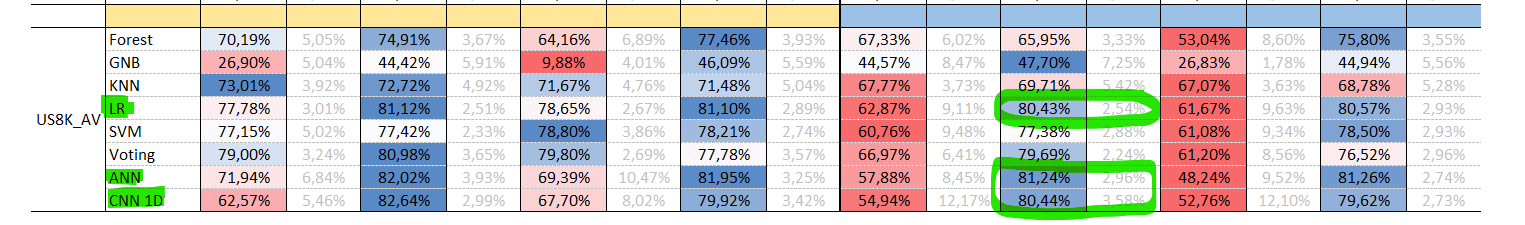

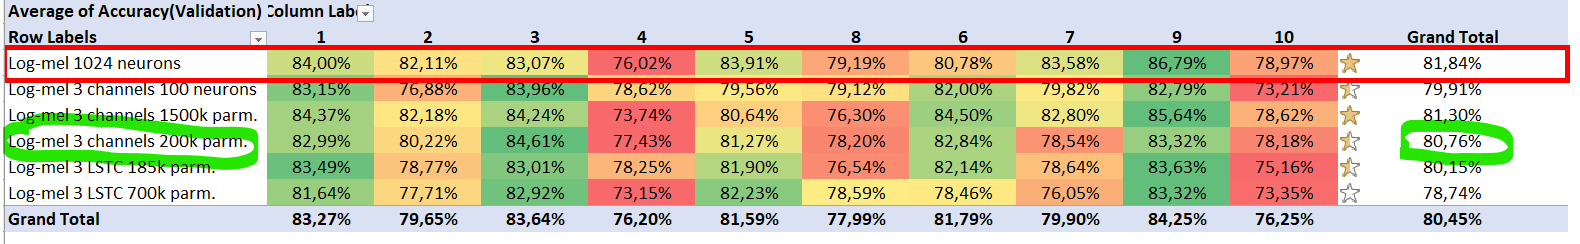

The "Log-mel 1024 neurons" and "Log-mel 3 channels 1500h param." models wer not choosen give its huge numbers of parameters (15.5M and 1.5M respectively). The third best model was defined instead as a compromise between accuracy and size.

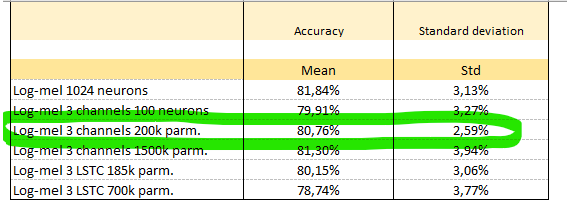


***
For the next steps, the fold 1 will be chosen as the validation set given it's presence in all selected classifiers.

* Fold 1 samples (validation): 2,968
* Training samples: 27,538 (24,784 training / 2,754 testing)
* Total:  30,506

***

## Checking the results with the classifiers saved models (windowed model)

### SVC - Expected results for fold 1 validation: 80.42% 

### SVC - Expected results for fold 1 validation based on k-fold cross-validation: 80.22% 

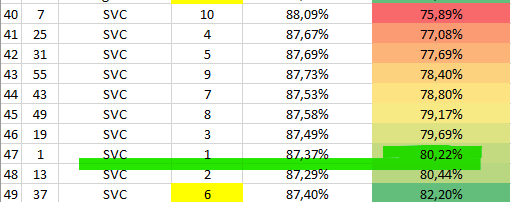

Images from the file: 04_ML_modeling.ipynb

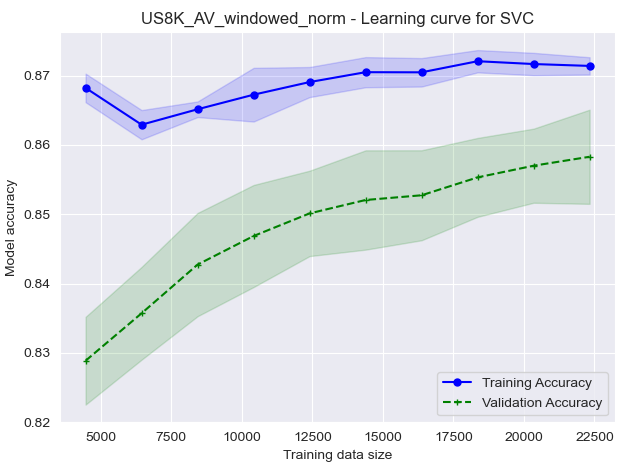

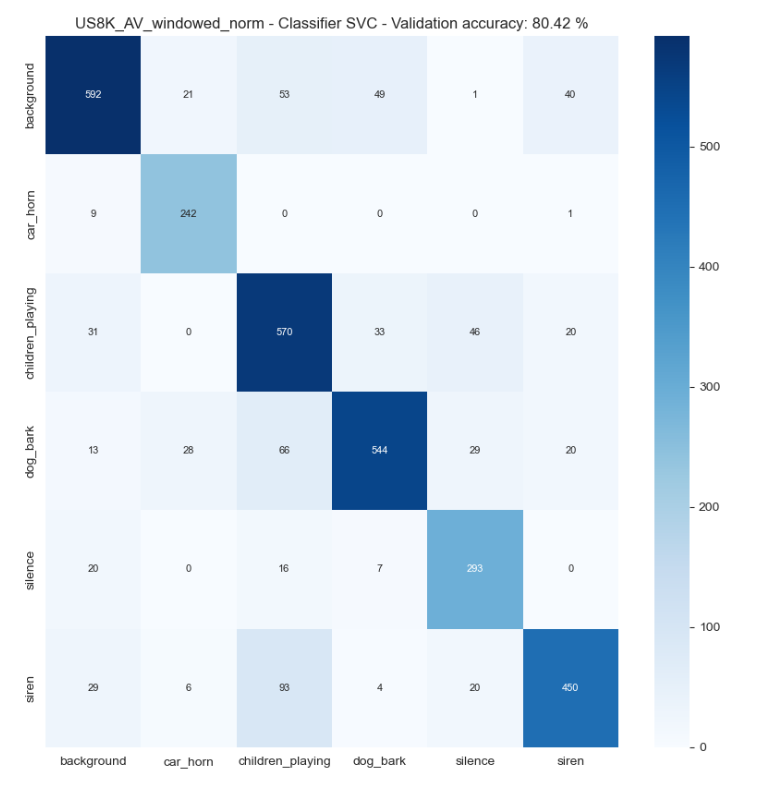

In [55]:
# Load the classifier from file

with open(os.path.join(path_modelsVal, 'Model_SVC_norm_windowed.pkl'), 'rb') as file:
    SVC_c_saved = pickle.load(file)

In [56]:
score_SVC_c_saved = SVC_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_SVC_c_saved))

Test score (R2): 80.42 %


In [57]:
score_SVC_c_saved

0.8042438732815301

In [58]:
t_srt                   = time.perf_counter_ns()
SVC_c_saved_predict_val = SVC_c_saved.predict(X_val_norm)
t_end                   = time.perf_counter_ns()
proc_time               = ((t_end - t_srt) / 1000000)

print(SVC_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'background' 'background'
 'background']

Number of predicted samples..: 3346
Total predicting time:.......: 8693.7309ms
Predicting time per sample...: 2.598246ms


In [59]:
SVC_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                             SVC_c_saved_predict_val, 
                                                             target_names = nom_classes, 
                                                             output_dict = False)
print(SVC_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.85      0.78      0.82       756
        car_horn       0.81      0.96      0.88       252
children_playing       0.71      0.81      0.76       700
        dog_bark       0.85      0.78      0.81       700
         silence       0.75      0.87      0.81       336
           siren       0.85      0.75      0.79       602

        accuracy                           0.80      3346
       macro avg       0.81      0.83      0.81      3346
    weighted avg       0.81      0.80      0.80      3346



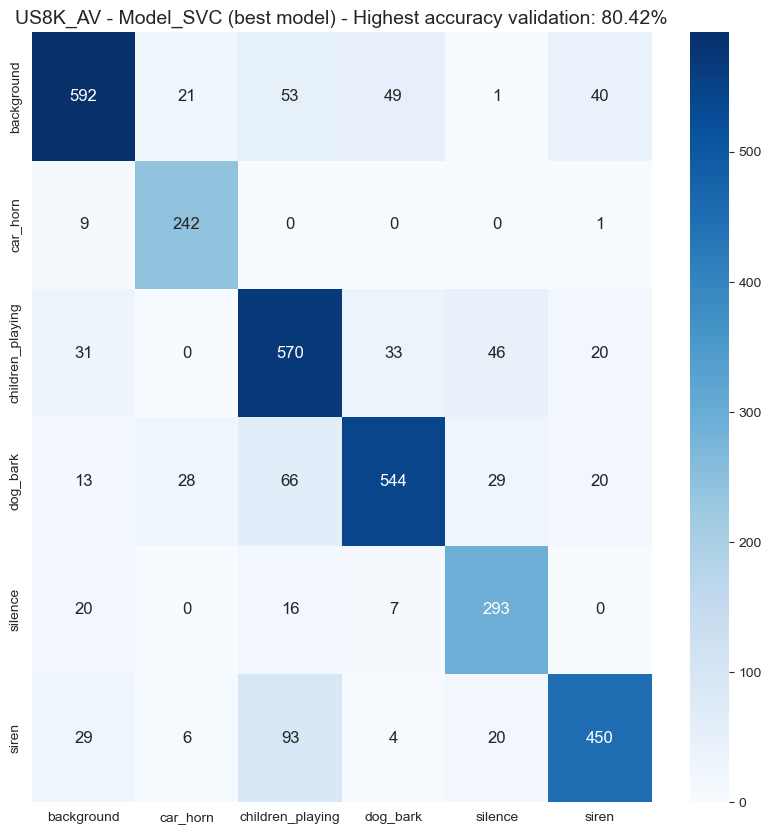

In [60]:
plot_confusion_matrix(y_val_cat, 
                      SVC_c_saved_predict_val, 
                      score_SVC_c_saved, 
                      cmap_cm, 
                      'Model_SVC_confusion_matrix',
                      ax = None,
                      savepic = False)

### LR - Expected results for fold 1 validation: 80.99% 

### LR - Expected results for fold 1 validation based on k-fold cross-validation: 81.23% 

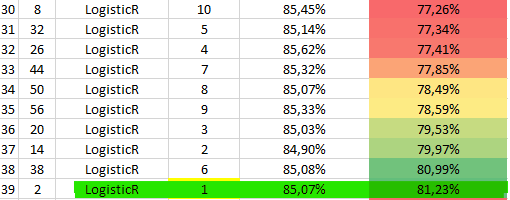

Images from the file: 04_ML_modeling.ipynb

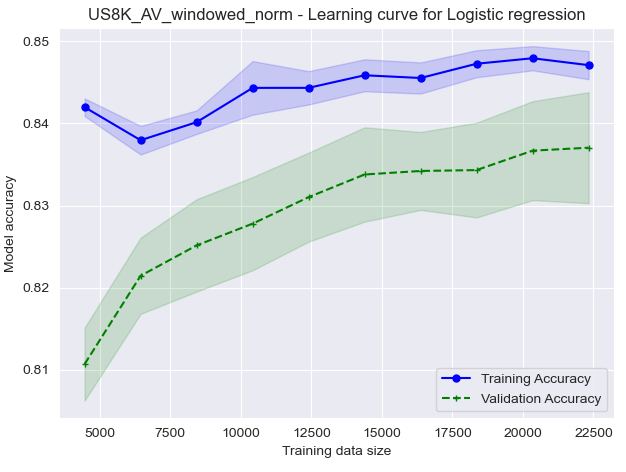

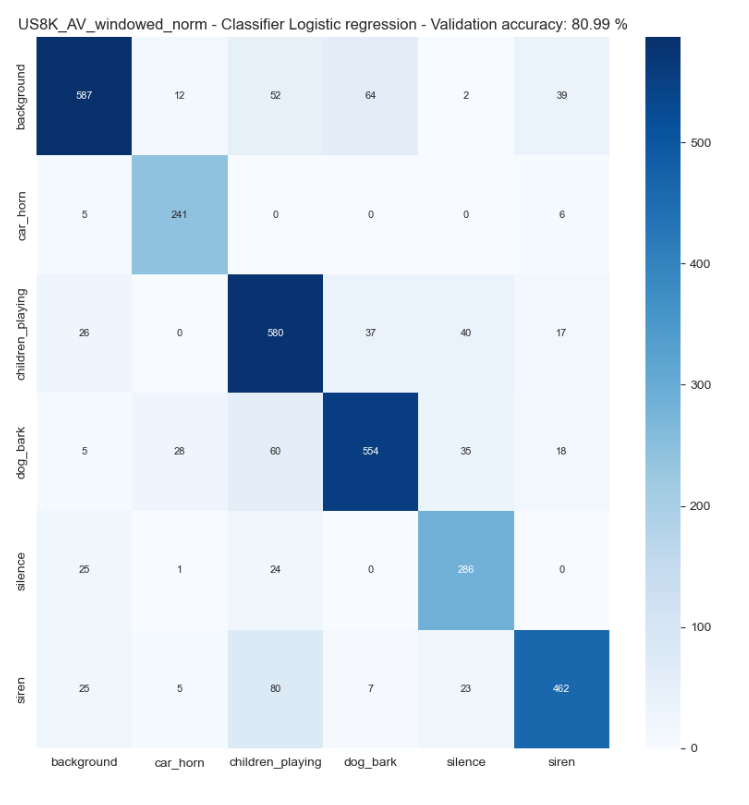

In [61]:
# Load the classifier from file

with open(os.path.join(path_modelsVal, 'Model_LogisticR_norm_windowed.pkl'), 'rb') as file:
    LR_c_saved = pickle.load(file)

In [62]:
score_LR_c_saved = LR_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_LR_c_saved))

Test score (R2): 80.99 %


In [63]:
score_LR_c_saved

0.8099222952779438

In [64]:
t_srt                  = time.perf_counter_ns()
LR_c_saved_predict_val = LR_c_saved.predict(X_val_norm)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(LR_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'background' 'background'
 'background']

Number of predicted samples..: 3346
Total predicting time:.......: 4.857ms
Predicting time per sample...: 0.001452ms


In [65]:
for i in LR_c_saved_predict_val:
    print(i)

dog_bark
dog_bark
dog_bark
silence
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
silence
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
silence
dog_bark
silence
background
children_playing
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
dog_bark
children_playing
children_playing
dog_bark
children_playing
children_playing
dog_bark
children_playing
children_playing
dog_bark
silence
dog_bark
dog_bark
children_playing
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
background
backgr

In [66]:
LR_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            LR_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(LR_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.87      0.78      0.82       756
        car_horn       0.84      0.96      0.89       252
children_playing       0.73      0.83      0.78       700
        dog_bark       0.84      0.79      0.81       700
         silence       0.74      0.85      0.79       336
           siren       0.85      0.77      0.81       602

        accuracy                           0.81      3346
       macro avg       0.81      0.83      0.82      3346
    weighted avg       0.82      0.81      0.81      3346



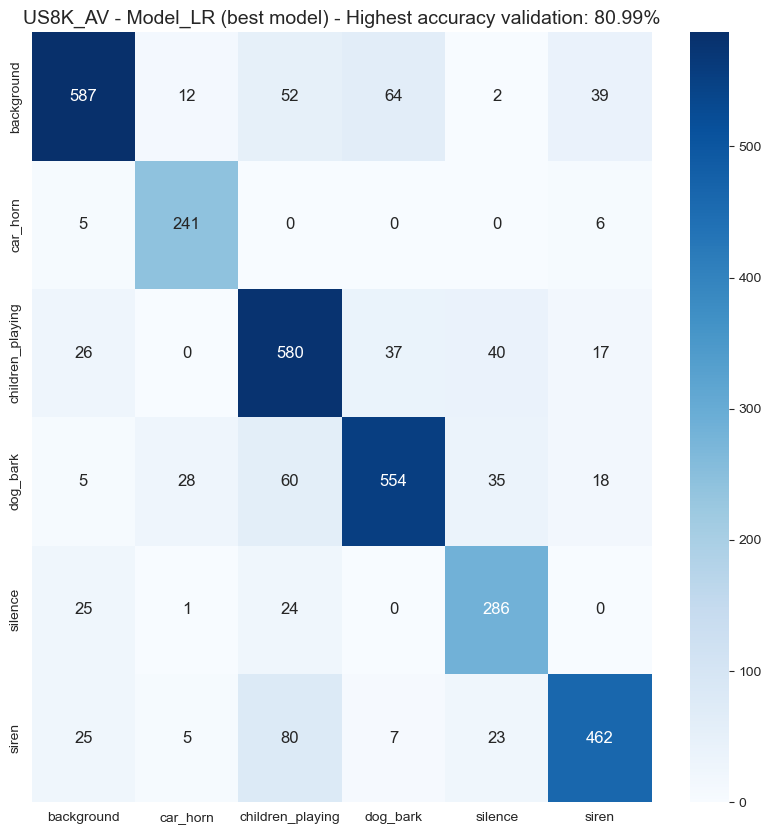

In [67]:
plot_confusion_matrix(y_val_cat, 
                      LR_c_saved_predict_val, 
                      score_LR_c_saved, 
                      cmap_cm, 
                      'Model_LR_confusion_matrix',
                      ax = None,
                      savepic = False)

### RF - Expected results for fold 1 validation: 80.04% 

### RF - Expected results for fold 1 validation based on k-fold cross-validation: 79.83% 

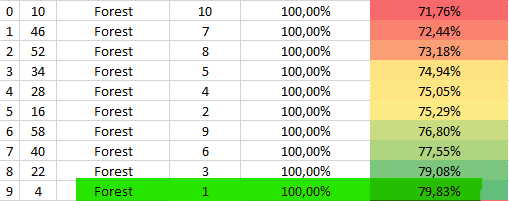

Images from the file: 04_ML_modeling.ipynb

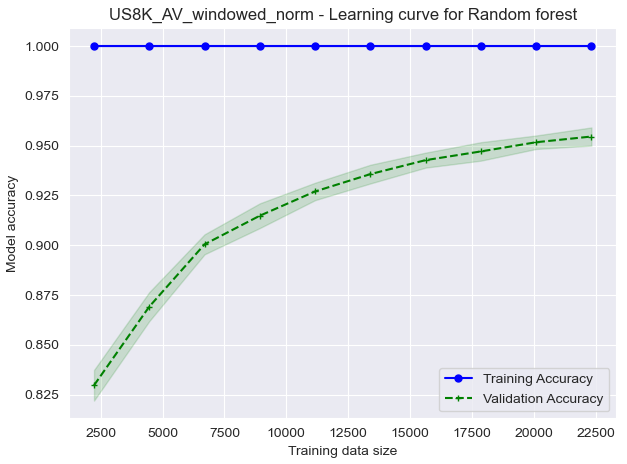

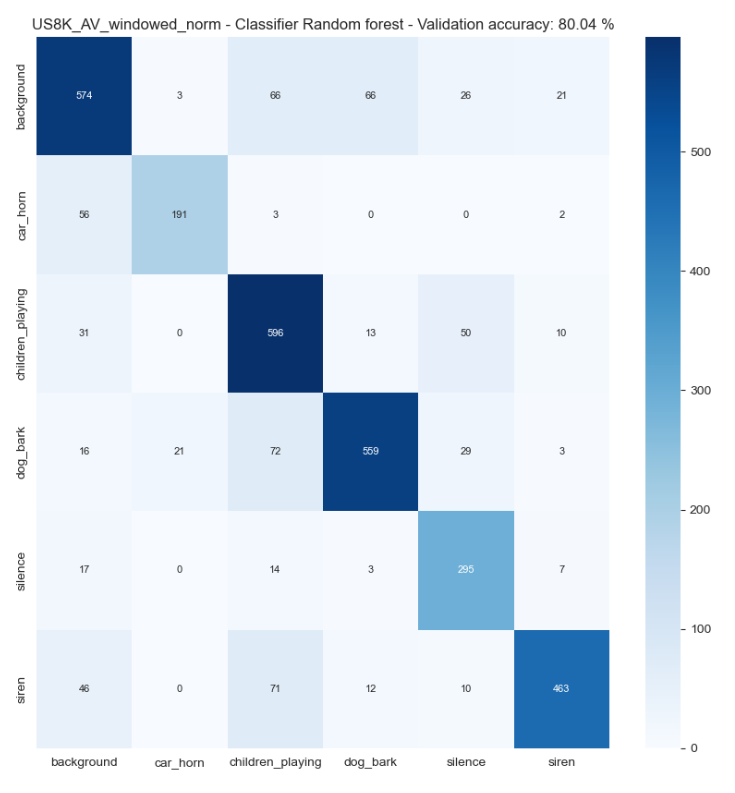

In [68]:
# Load the classifier from file

with open(os.path.join(path_modelsVal,  'Model_Forest_norm_windowed.pkl'), 'rb') as file:
    RF_c_saved = pickle.load(file)

In [69]:
score_RF_c_saved = RF_c_saved.score(X_val_norm, y_val_cat)
print("Test score (R2): {0:.2f} %".format(100 * score_RF_c_saved))

Test score (R2): 80.04 %


In [70]:
score_RF_c_saved

0.8003586371787209

In [71]:
t_srt                  = time.perf_counter_ns()
RF_c_saved_predict_val = RF_c_saved.predict(X_val_norm)
t_end                  = time.perf_counter_ns()
proc_time              = ((t_end - t_srt) / 1000000)

print(RF_c_saved_predict_val)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

['dog_bark' 'dog_bark' 'dog_bark' ... 'siren' 'siren' 'siren']

Number of predicted samples..: 3346
Total predicting time:.......: 263.7727ms
Predicting time per sample...: 0.078832ms


In [72]:
RF_c_saved_val_class_report = metrics.classification_report(y_val_cat, 
                                                            RF_c_saved_predict_val, 
                                                            target_names = nom_classes, 
                                                            output_dict = False)
print(RF_c_saved_val_class_report)

                  precision    recall  f1-score   support

      background       0.78      0.76      0.77       756
        car_horn       0.89      0.76      0.82       252
children_playing       0.73      0.85      0.78       700
        dog_bark       0.86      0.80      0.83       700
         silence       0.72      0.88      0.79       336
           siren       0.92      0.77      0.84       602

        accuracy                           0.80      3346
       macro avg       0.81      0.80      0.80      3346
    weighted avg       0.81      0.80      0.80      3346



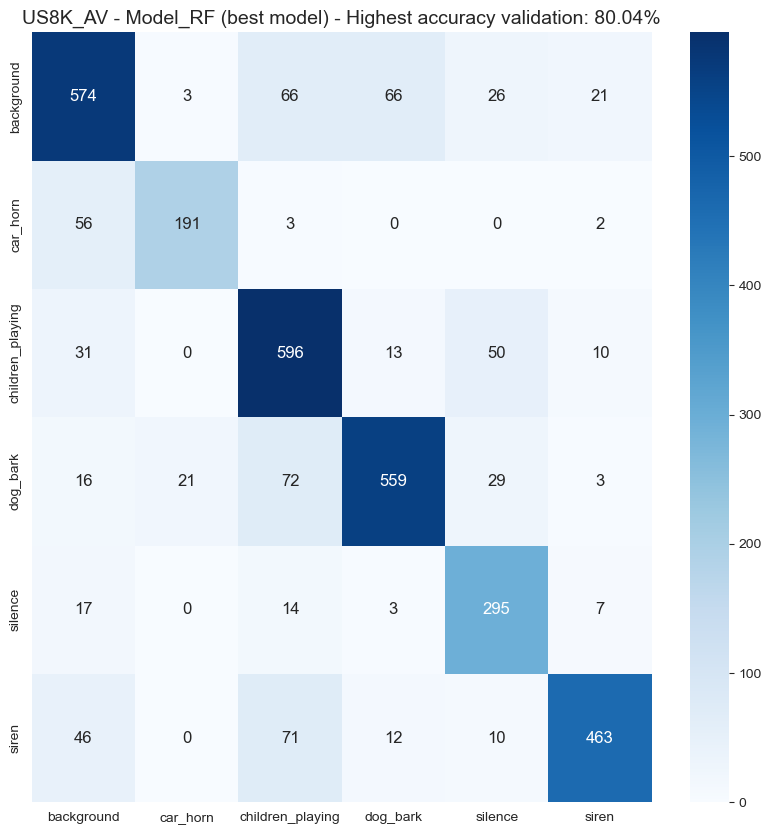

In [73]:
plot_confusion_matrix(y_val_cat, 
                      RF_c_saved_predict_val, 
                      score_RF_c_saved, 
                      cmap_cm, 
                      'Model_RF_confusion_matrix',
                      ax = None,
                      savepic = False)

### MLP - Expected results for fold 1 validation: 78.24% 

### MLP - Expected results for fold 1 validation based on k-fold cross-validation: 77.32% 

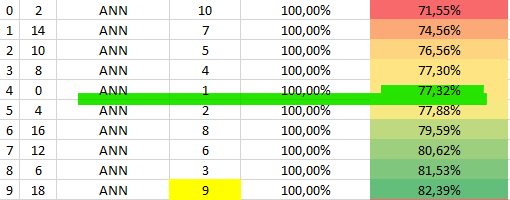

Images from the file: 04_ML_modeling.ipynb

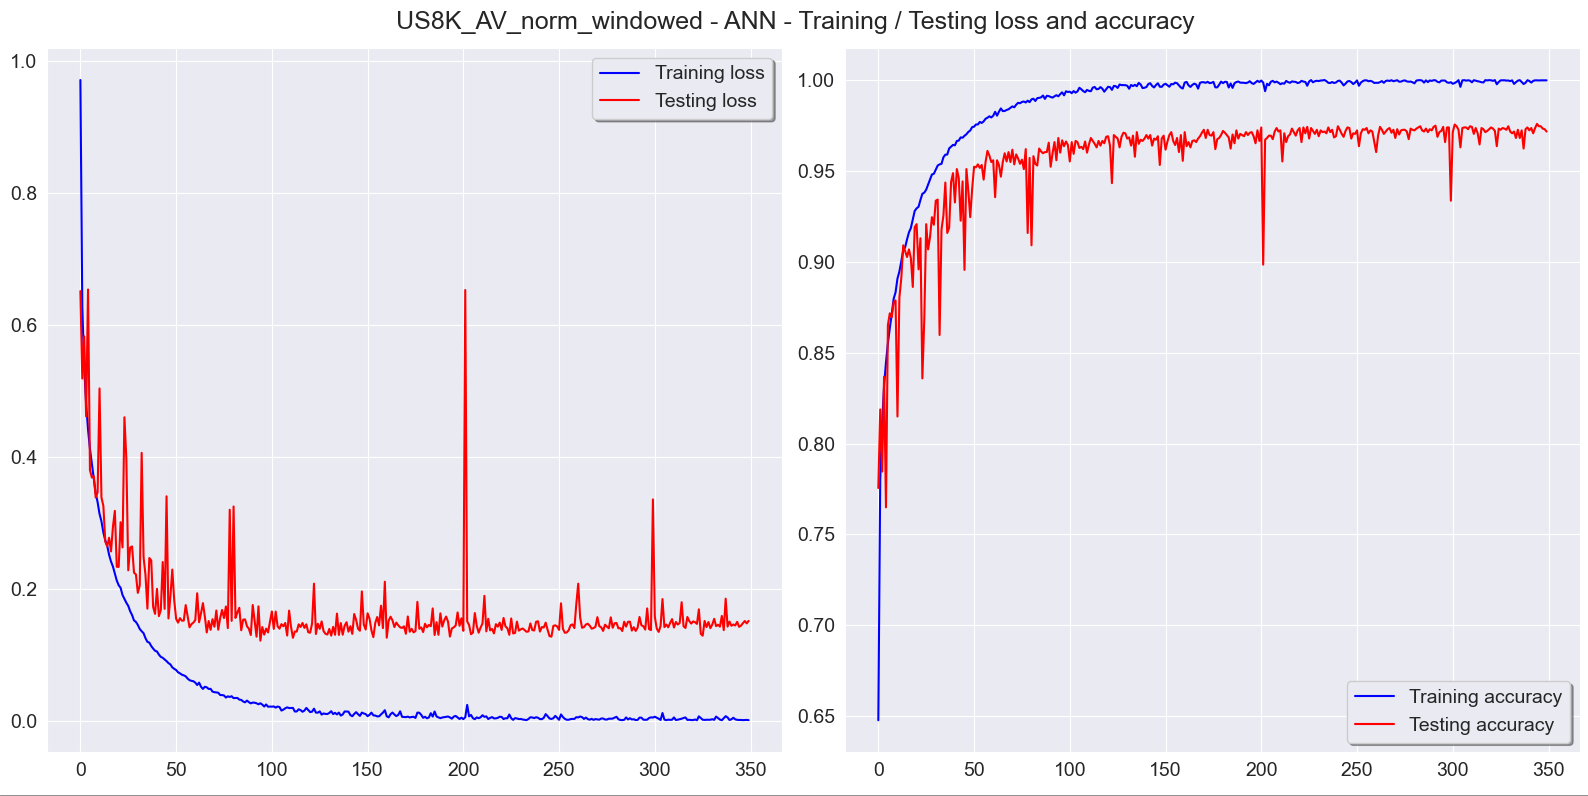

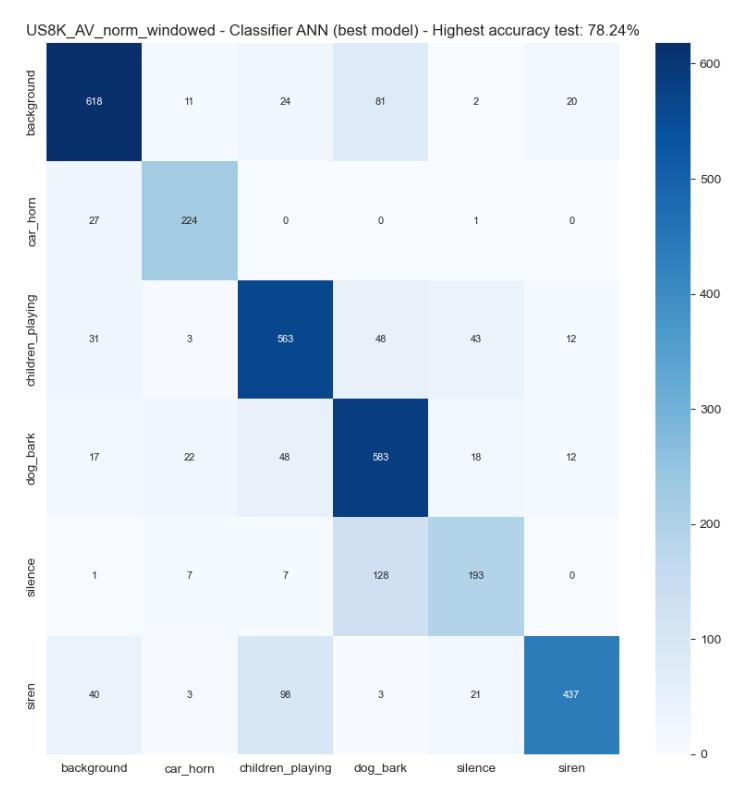

In [74]:
# Load the model with the highest accuracy

model_ANN_saved = load_model(os.path.join(path_modelsVal,  'Model_ANN_weights_0_best_norm_windowed.hdf5'))
model_ANN_saved.summary()

Model: "ANN_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 375)               141000    
_________________________________________________________________
Hiden_1 (Dense)              (None, 375)               141000    
_________________________________________________________________
Dropout_1 (Dropout)          (None, 375)               0         
_________________________________________________________________
Hiden_2 (Dense)              (None, 750)               282000    
_________________________________________________________________
Dropout_2 (Dropout)          (None, 750)               0         
_________________________________________________________________
Output (Dense)               (None, 6)                 4506      
Total params: 568,506
Trainable params: 568,506
Non-trainable params: 0
_______________________________________________________

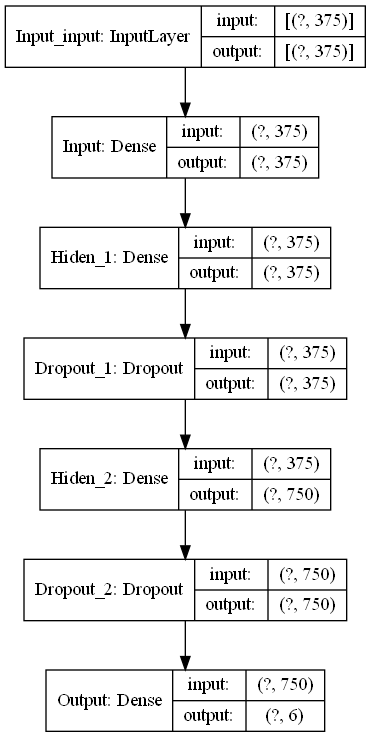

In [75]:
tf.keras.utils.plot_model(model_ANN_saved,  show_shapes=True)

In [76]:
score_ANN_saved = model_ANN_saved.evaluate(X_val_norm, y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_ANN_saved[0])
print('Test accuracy:', score_ANN_saved[1])

105/105 [==============================] - 0s 2ms/step - loss: 2.9545 - accuracy: 0.7824
Test loss: 2.9545063972473145
Test accuracy: 0.7824267745018005


In [77]:
score_ANN_saved[1]

0.7824267745018005

In [78]:
t_srt            = time.perf_counter_ns()
y_pred_ANN_saved = np.argmax(model_ANN_saved.predict(X_val_norm),axis=1)
t_end            = time.perf_counter_ns()
proc_time        = ((t_end - t_srt) / 1000000)

print(y_pred_ANN_saved)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

[3 3 3 ... 1 1 1]

Number of predicted samples..: 3346
Total predicting time:.......: 209.118ms
Predicting time per sample...: 0.062498ms


In [79]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [80]:
metrics_set_ANN = classification_report(y_test_enc, y_pred_ANN_saved, target_names=nom_classes)
print(metrics_set_ANN)

                  precision    recall  f1-score   support

      background       0.84      0.82      0.83       756
        car_horn       0.83      0.89      0.86       252
children_playing       0.76      0.80      0.78       700
        dog_bark       0.69      0.83      0.76       700
         silence       0.69      0.57      0.63       336
           siren       0.91      0.73      0.81       602

        accuracy                           0.78      3346
       macro avg       0.79      0.77      0.78      3346
    weighted avg       0.79      0.78      0.78      3346



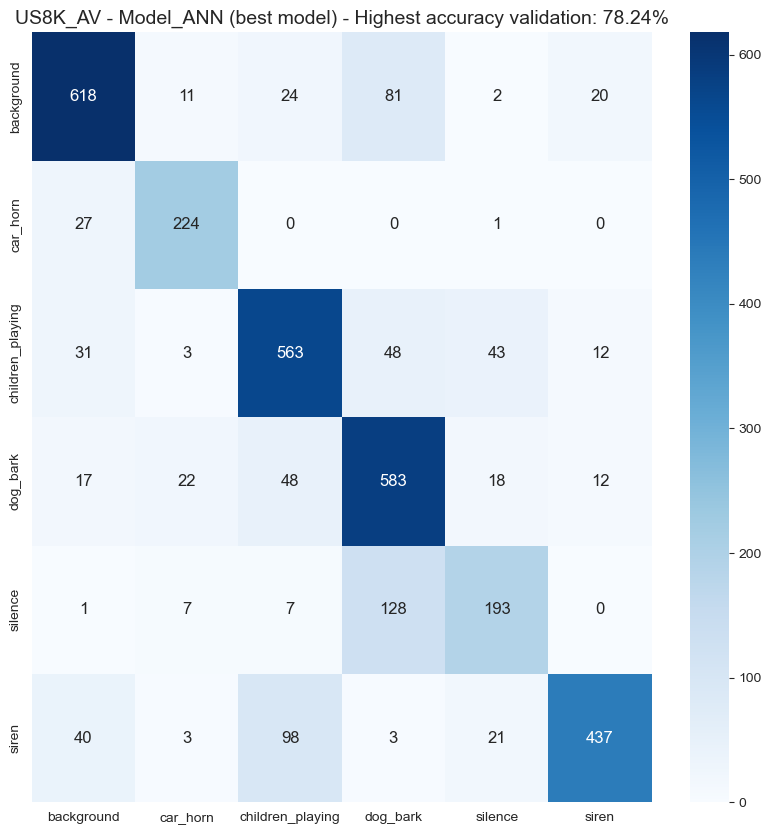

In [81]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_ANN_saved, 
                      score_ANN_saved, 
                      cmap_cm, 
                      'Model_ANN_confusion_matrix',
                      ax = None,
                      savepic = False)

### CNN 1D - Expected results for fold 1 validation: 77.08% 

### CNN 1D - Expected results for fold 1 validation based on k-fold cross-validation: 79.17% 

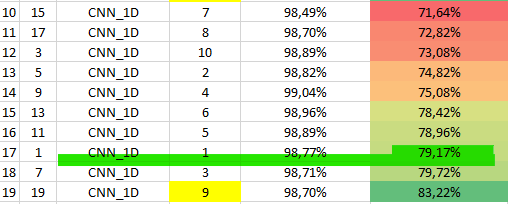

Images from the file: 04_ML_modeling.ipynb

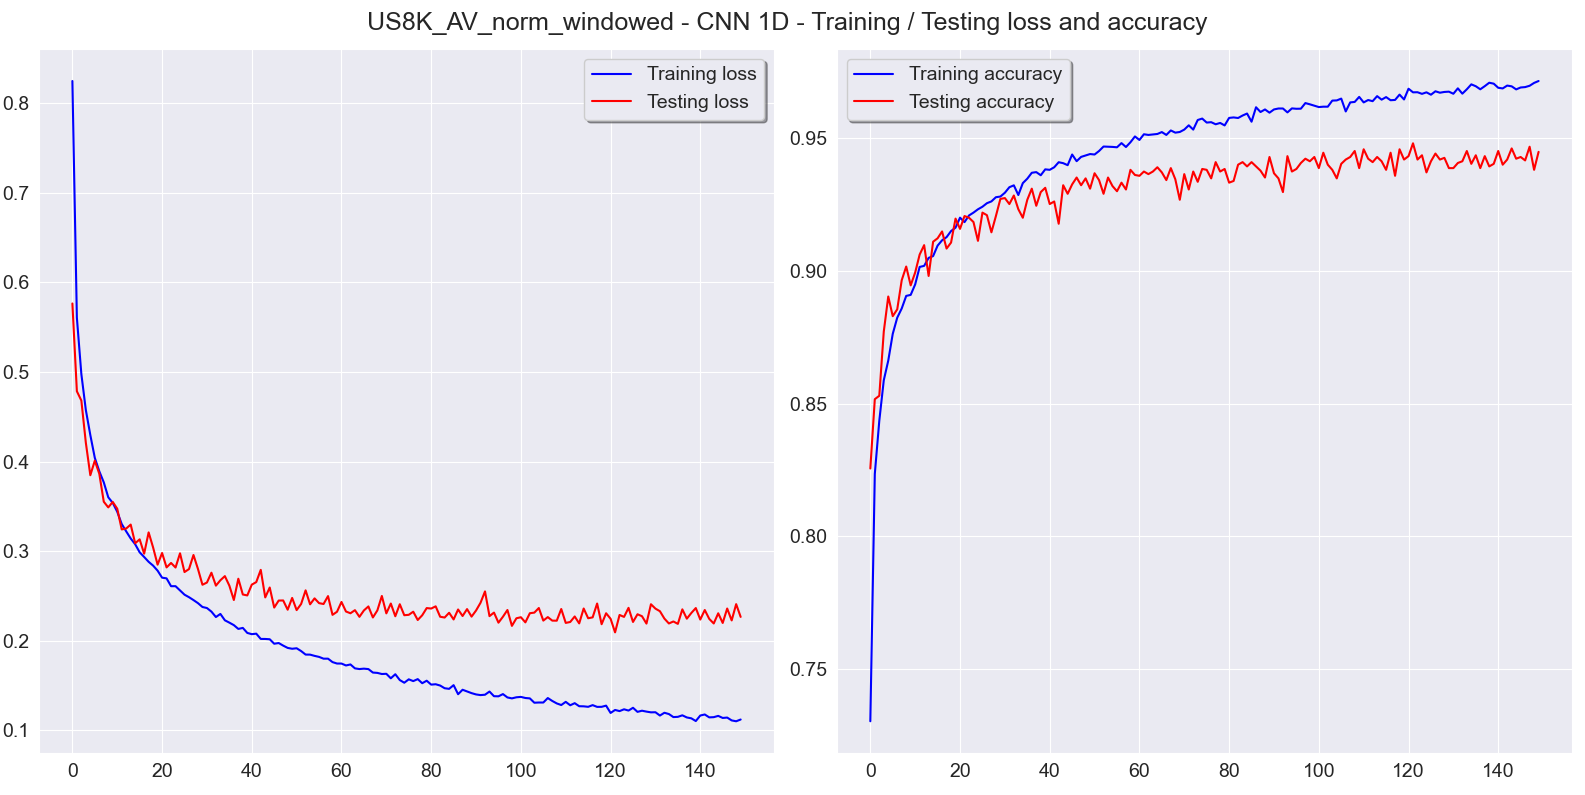

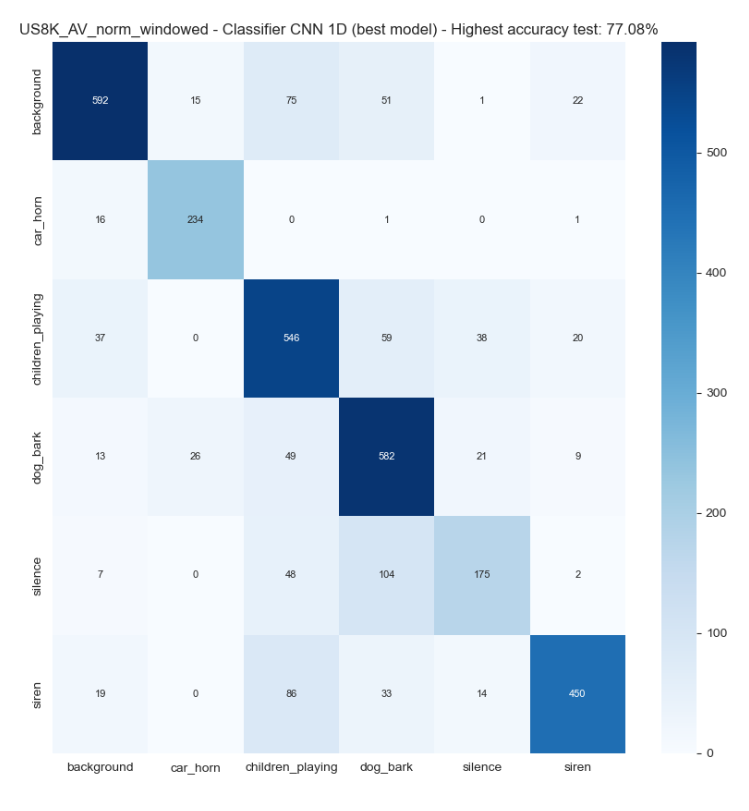

In [82]:
# Load the model with the highest accuracy

model_CNN_1D_saved = load_model(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.hdf5'))
model_CNN_1D_saved.summary()

Model: "CNN_1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 369, 28)           224       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 369, 34)           4794      
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 369, 56)           5768      
_________________________________________________________________
MaxPool1D_3 (MaxPooling1D)   (None, 184, 56)           0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 184, 56)           0         
_________________________________________________________________
flatten (Flatten)            (None, 10304)             0         
_________________________________________________________________
Dense (Dense)                (None, 50)                51525

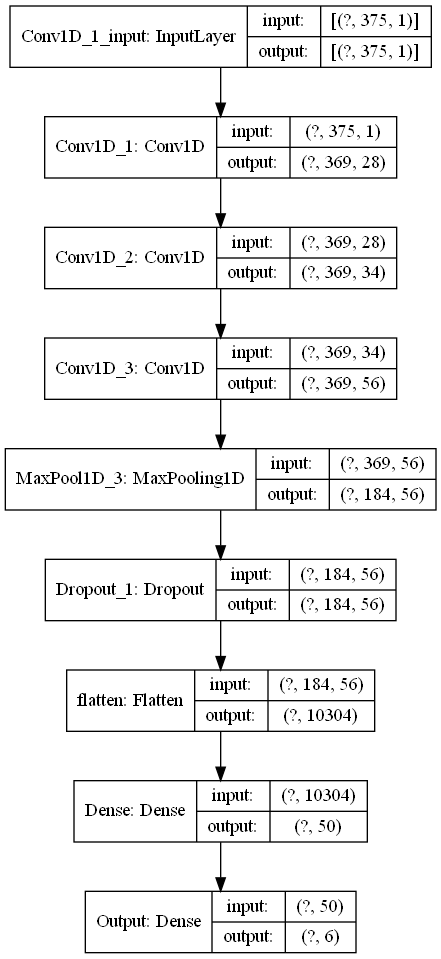

In [83]:
tf.keras.utils.plot_model(model_CNN_1D_saved,  show_shapes=True)

In [84]:
score_CNN_1D_saved = model_CNN_1D_saved.evaluate(X_val_norm[..., np.newaxis], y_OHEV_val, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_1D_saved[0])
print('Test accuracy:', score_CNN_1D_saved[1])

105/105 [==============================] - 0s 3ms/step - loss: 1.6422 - accuracy: 0.7708
Test loss: 1.6421911716461182
Test accuracy: 0.7707710862159729


In [85]:
score_CNN_1D_saved[1]

0.7707710862159729

In [86]:
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 5, 0, 0], dtype=int64)

In [87]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_1D_saved = np.argmax(model_CNN_1D_saved.predict(X_val_norm[..., np.newaxis]),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_1D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_norm)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_norm),6)}ms')

[3 3 3 ... 5 0 0]

Number of predicted samples..: 3346
Total predicting time:.......: 168.2367ms
Predicting time per sample...: 0.05028ms


In [88]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [89]:
metrics_set_CNN_1D_saved = classification_report(y_test_enc, y_pred_CNN_1D_saved, target_names=nom_classes)
print(metrics_set_CNN_1D_saved)

                  precision    recall  f1-score   support

      background       0.87      0.78      0.82       756
        car_horn       0.85      0.93      0.89       252
children_playing       0.68      0.78      0.73       700
        dog_bark       0.70      0.83      0.76       700
         silence       0.70      0.52      0.60       336
           siren       0.89      0.75      0.81       602

        accuracy                           0.77      3346
       macro avg       0.78      0.77      0.77      3346
    weighted avg       0.78      0.77      0.77      3346



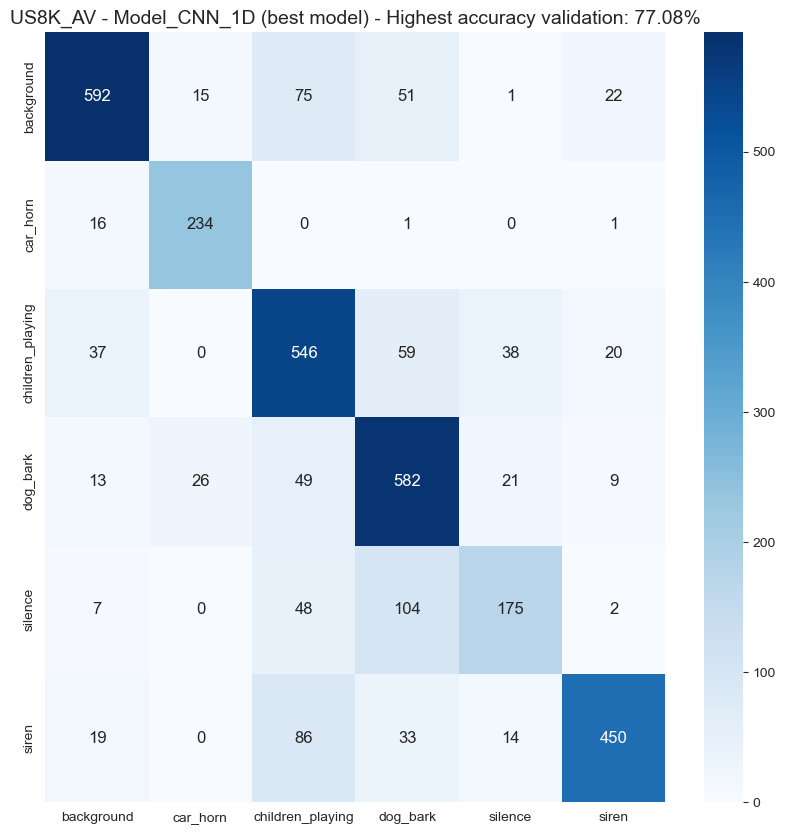

In [90]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_1D_saved, 
                      score_CNN_1D_saved, 
                      cmap_cm, 
                      'Model_CNN_1D_confusion_matrix',
                      ax = None,
                      savepic = False)

### CNN 2D - Expected results for fold 1 validation: 81.71% 

### CNN 2D - Expected results for fold 1 validation based on k-fold cross-validation: 80.54% 

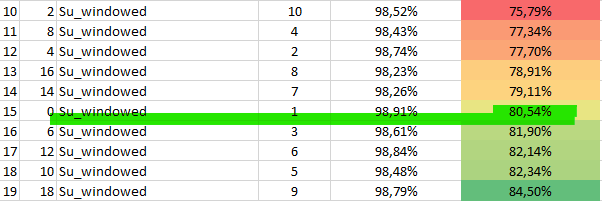

Images from the file: 09_CNN_2D.ipynb

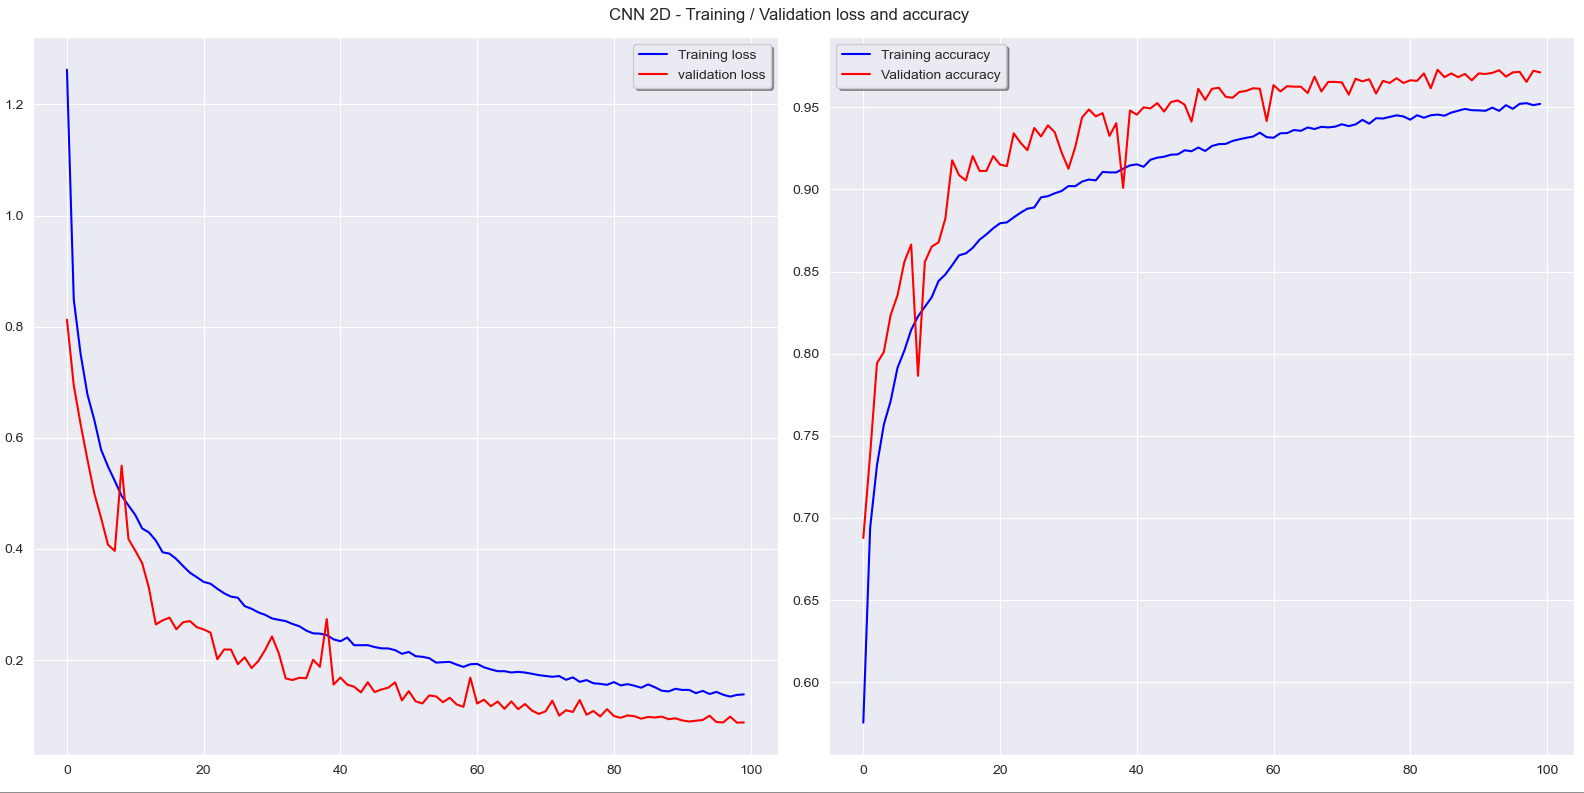

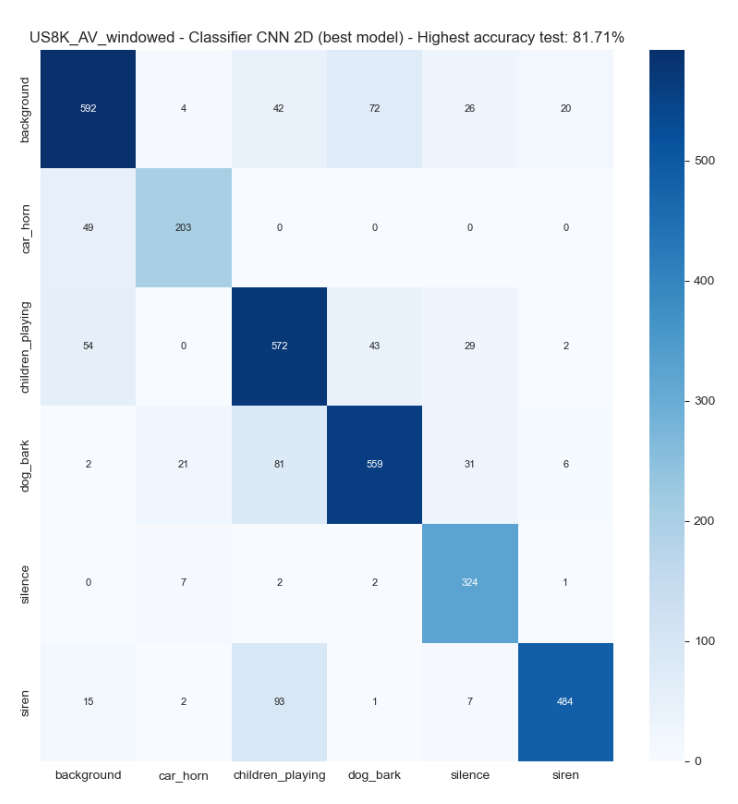

In [91]:
# Load the model with the highest accuracy

model_CNN_2D_saved = load_model(os.path.join(path_modelsVal,  'Model_CNN_2D_weights_0_best_windowed.hdf5'))
model_CNN_2D_saved.summary()

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 90, 22, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 90, 22, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 10, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 44, 10, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 5, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 5, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 5, 64)     

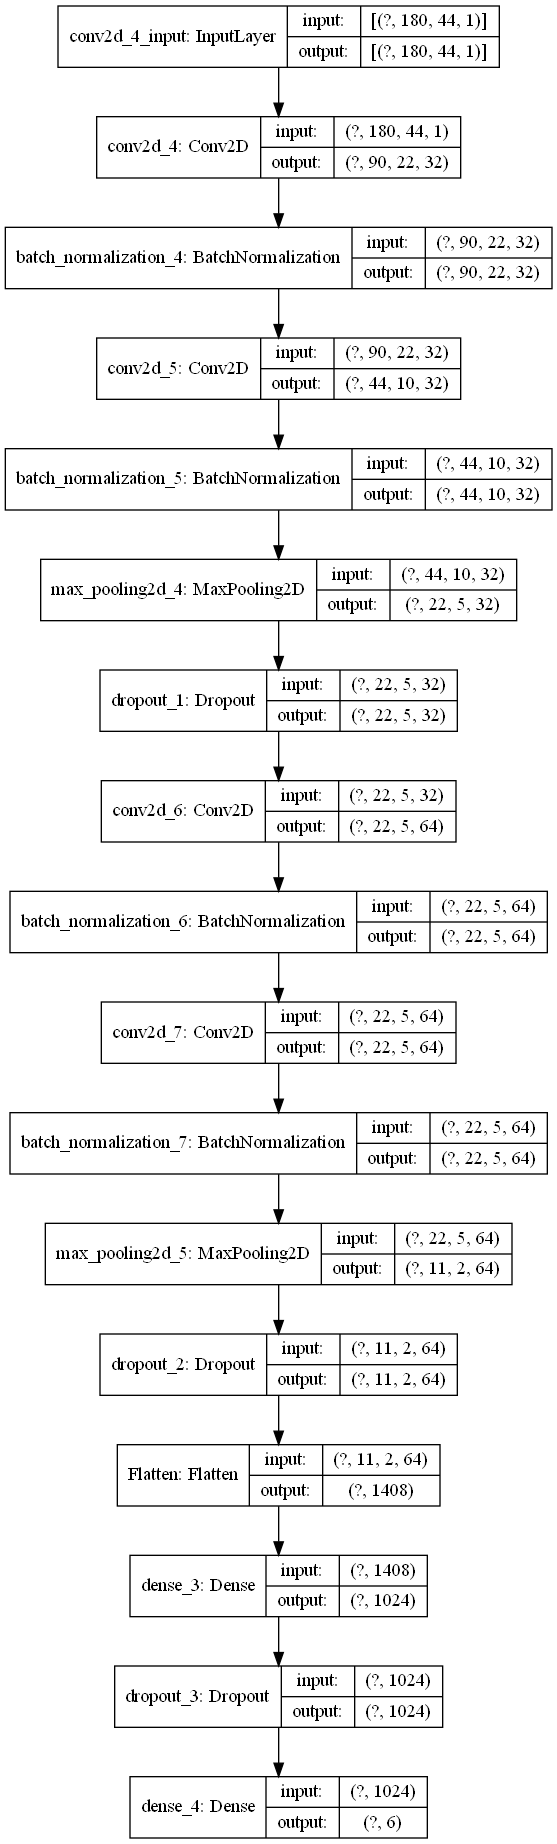

In [92]:
tf.keras.utils.plot_model(model_CNN_2D_saved,  show_shapes=True)

In [93]:
score_CNN_2D_saved = model_CNN_2D_saved.evaluate(X_val_CNN2D, y_val_CNN2D, verbose=1, batch_size = 32)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

105/105 [==============================] - 0s 4ms/step - loss: 0.8453 - accuracy: 0.8171
Test loss: 0.845297634601593
Test accuracy: 0.8170950412750244


In [94]:
score_CNN_2D_saved[1]

0.8170950412750244

In [95]:
t_srt               = time.perf_counter_ns()
y_pred_CNN_2D_saved = np.argmax(model_CNN_2D_saved.predict(X_val_CNN2D),axis=1)
t_end               = time.perf_counter_ns()
proc_time           = ((t_end - t_srt) / 1000000)

print(y_pred_CNN_2D_saved)
print(f'\nNumber of predicted samples..: {len(X_val_CNN2D)}')
print(f'Total predicting time:.......: {proc_time}ms')

print(f'Predicting time per sample...: {round(proc_time/len(X_val_CNN2D),6)}ms')

[3 3 3 ... 1 1 1]

Number of predicted samples..: 3346
Total predicting time:.......: 267.4391ms
Predicting time per sample...: 0.079928ms


In [96]:
y_test_enc = np.argmax(y_val_CNN2D, axis=1)
y_test_enc

array([3, 3, 3, ..., 4, 4, 4], dtype=int64)

In [97]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.83      0.78      0.81       756
        car_horn       0.86      0.81      0.83       252
children_playing       0.72      0.82      0.77       700
        dog_bark       0.83      0.80      0.81       700
         silence       0.78      0.96      0.86       336
           siren       0.94      0.80      0.87       602

        accuracy                           0.82      3346
       macro avg       0.83      0.83      0.82      3346
    weighted avg       0.82      0.82      0.82      3346



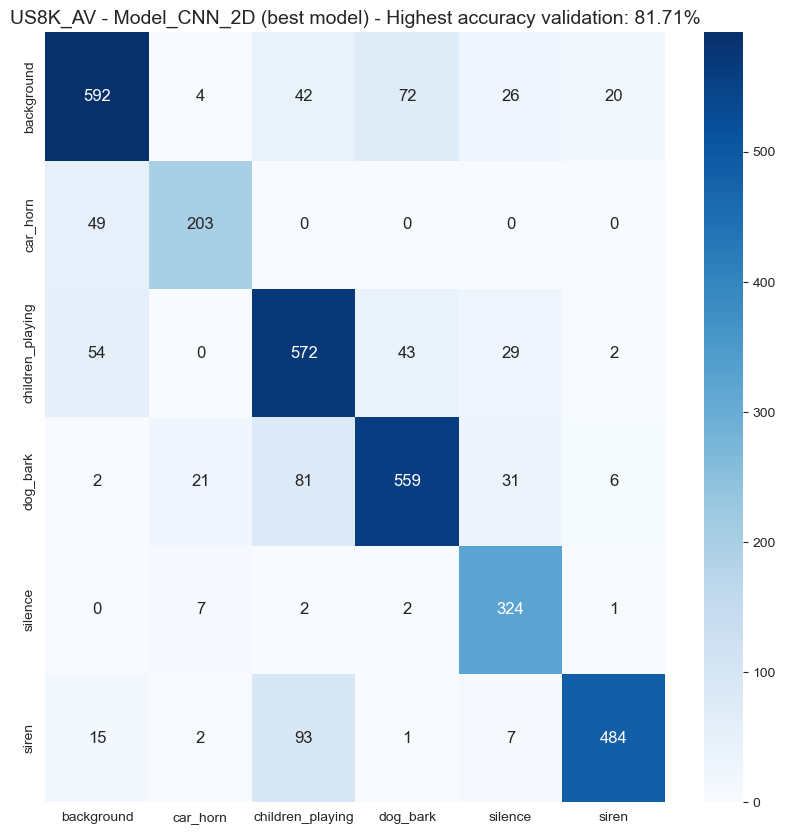

In [98]:
plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_2D_saved, 
                      score_CNN_2D_saved, 
                      cmap_cm, 
                      'Model_CNN_2D_confusion_matrix',
                      ax = None,
                      savepic = False)

### Feature extraction evaluation on the validation set

Select the original audio for the validation set

In [99]:
val_audioW = np.array(DB_aug_from_pkl_VAL.Audio.to_list())
val_audioW.shape

(3346, 22016)

In [100]:
val_audio = np.array(DB_ori_from_pkl_VAL.Audio.to_list())
val_audio

array([[ 6.40211074e-05,  8.26949836e-05,  5.21230577e-05, ...,
        -9.90534551e-04, -1.04527897e-03, -1.12278771e-03],
       [-1.63099641e-04, -1.47700383e-04, -1.09524306e-04, ...,
         8.95090925e-04,  1.02632504e-03,  1.10134820e-03],
       [ 2.32642919e-01,  3.51767898e-01,  2.96772093e-01, ...,
         1.11169368e-01,  8.34129453e-02,  5.04262894e-02],
       ...,
       [-4.24975455e-02, -6.46661744e-02, -5.70580289e-02, ...,
         3.72168142e-03,  3.44587583e-03,  4.22332343e-03],
       [ 2.85713468e-03,  3.98859056e-03,  3.28775542e-03, ...,
        -7.79237540e-04, -7.33654597e-04, -8.12655722e-04],
       [-6.16295205e-04, -8.93199060e-04, -8.59586929e-04, ...,
         3.40836123e-04,  3.41486360e-04,  3.47480876e-04]], dtype=float32)

In [101]:
val_audio.shape

(478, 88200)

In [102]:
y_val_audio_cat = np.array(DB_ori_from_pkl_VAL.Class_categorical.to_list())
y_val_audio_cat

array(['dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'background',
       'background', 'background', 'background', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'siren', 'siren', 'siren', 'siren',
       'background', 'background', 'background', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'children_playing', 'children_playing',
       'children_playing', 'background', 'background', 'background',
       'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark', 'dog_bark',
       'dog_bark', 'dog_bark', 'dog_bark', 'siren', 'siren', 'siren'

In [103]:
y_val_audio_cat.shape

(478,)

In [104]:
y_val_audio_cat[1]

'dog_bark'

In [105]:
y_val_audio = np.array(DB_ori_from_pkl_VAL.Class_OHEV.to_list())
y_val_audio

array([[0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]])

In [106]:
y_val_audio.shape

(478, 6)

In [107]:
ipd.Audio(val_audio[0], rate = SR)

### Quantization of the neural network models

Conversion of hdf5 files to Tensorflow lite (tflite):

* Model_ANN_weights_0_best_norm_windowed.hdf5
* Model_CNN_1D_weights_0_best_norm_windowed.hdf5
* Model_CNN_2D_weights_0_best_windowed.hdf5

In [108]:
print(model_ANN_saved)
print(model_CNN_1D_saved)
print(model_CNN_2D_saved)

In [109]:
#Convert to tflite
converter_ANN   = tf.lite.TFLiteConverter.from_keras_model(model_ANN_saved)
converter_CNN1D = tf.lite.TFLiteConverter.from_keras_model(model_CNN_1D_saved)
converter_CNN2D = tf.lite.TFLiteConverter.from_keras_model(model_CNN_2D_saved)

#Implement optimization strategy for smaller model sizes
converter_ANN.optimizations   = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
converter_CNN1D.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
converter_CNN2D.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size

tflite_model_ANN   = converter_ANN.convert()
open(os.path.join(path_modelsVal, 'Model_ANN_weights_0_best_norm_windowed.tflite'), "wb").write(tflite_model_ANN)

tflite_model_CNN1D = converter_CNN1D.convert()
open(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.tflite'), "wb").write(tflite_model_CNN1D)

tflite_model_CNN2D   = converter_CNN2D.convert()
open(os.path.join(path_modelsVal, 'Model_CNN_2D_weights_0_best_windowed.tflite'), "wb").write(tflite_model_CNN2D)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmprmbj3fug\assets
INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp9cszpgq5\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp9cszpgq5\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp1bkjmklv\assets


INFO:tensorflow:Assets written to: C:\Users\af21280\AppData\Local\Temp\tmp1bkjmklv\assets


1527248

### Inference of the tflite models

In [110]:
# Load the TFLite model and allocate tensors

interpreter_ANN   = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_ANN_weights_0_best_norm_windowed.tflite'))
interpreter_ANN.allocate_tensors()

interpreter_CNN1D = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_CNN_1D_weights_0_best_norm_windowed.tflite'))
interpreter_CNN1D.allocate_tensors()

interpreter_CNN2D = tf.lite.Interpreter(os.path.join(path_modelsVal, 'Model_CNN_2D_weights_0_best_windowed.tflite'))
interpreter_CNN2D.allocate_tensors()

In [111]:
# Get input and output tensors.
input_details_ANN    = interpreter_ANN.get_input_details()
output_details_ANN   = interpreter_ANN.get_output_details()

input_details_CNN1D  = interpreter_CNN1D.get_input_details()
output_details_CNN1D = interpreter_CNN1D.get_output_details()

input_details_CNN2D  = interpreter_CNN2D.get_input_details()
output_details_CNN2D = interpreter_CNN2D.get_output_details()

In [112]:
input_details_ANN

[{'name': 'Input_input',
  'index': 0,
  'shape': array([  1, 375]),
  'shape_signature': array([ -1, 375]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [113]:
output_details_ANN

[{'name': 'Identity',
  'index': 13,
  'shape': array([1, 6]),
  'shape_signature': array([-1,  6]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [114]:
input_details_CNN1D

[{'name': 'Conv1D_1_input',
  'index': 0,
  'shape': array([  1, 375,   1]),
  'shape_signature': array([ -1, 375,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [115]:
output_details_CNN1D

[{'name': 'Identity',
  'index': 35,
  'shape': array([1, 6]),
  'shape_signature': array([-1,  6]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [116]:
input_details_CNN1D

[{'name': 'Conv1D_1_input',
  'index': 0,
  'shape': array([  1, 375,   1]),
  'shape_signature': array([ -1, 375,   1]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [117]:
output_details_CNN2D

[{'name': 'Identity',
  'index': 39,
  'shape': array([1, 6]),
  'shape_signature': array([-1,  6]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [118]:
input_shape_ANN   = input_details_ANN[0]['shape']
input_shape_CNN1D = input_details_CNN1D[0]['shape']
input_shape_CNN2D = input_details_CNN2D[0]['shape']

print(f'Input shape ANN:....{input_shape_ANN}')
print(f'Input shape CNN1D...{input_shape_CNN1D}')
print(f'Input shape CNN2D...{input_shape_CNN2D}')

Input shape ANN:....[  1 375]
Input shape CNN1D...[  1 375   1]
Input shape CNN2D...[  1 180  44   1]


#### Convert the input data to the expected format of the tflite model

In [119]:
print(input_details_ANN[0]['dtype'])
print(input_details_CNN1D[0]['dtype'])
print(input_details_CNN2D[0]['dtype'])

<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.float32'>


In [120]:
type(X_val_norm[0][0])

numpy.float64

In [121]:
X_val_norm_tflite = X_val_norm.astype(input_details_ANN[0]['dtype'])
print(X_val_norm_tflite.shape)
print(type(X_val_norm_tflite[0][0]))

(3346, 375)
<class 'numpy.float32'>


### Inference ANN tflite

In [122]:
input_details_ANN[0]['shape']

array([  1, 375])

In [123]:
t = X_val_norm_tflite[0].reshape(1,-1).shape
t

(1, 375)

In [124]:
interpreter_ANN.set_tensor(input_details_ANN[0]['index'], X_val_norm_tflite[0].reshape(1,-1))

In [125]:
interpreter_ANN.invoke()

In [126]:
prediction_tflite_ANN = np.argmax(interpreter_ANN.get_tensor(output_details_ANN[0]['index']), axis=1)
prediction_tflite_ANN

array([3], dtype=int64)

In [127]:
predictions_tflite_ANN= []

for sample in X_val_norm_tflite:
    interpreter_ANN.set_tensor(input_details_ANN[0]['index'], sample.reshape(1,-1))
    interpreter_ANN.invoke()
    prediction_sample_ANN = np.argmax(interpreter_ANN.get_tensor(output_details_ANN[0]['index']), axis=1)
    predictions_tflite_ANN.append(prediction_sample_ANN[0])

predictions_tflite_ANN = np.array(predictions_tflite_ANN)

In [128]:
predictions_tflite_ANN

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [129]:
#predictions_tflite_ANN.tofile(os.path.join(path_arrays, '_saved_predict_val_ANN_tflite.csv'), sep=',')

In [130]:
y_pred_ANN_saved

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [131]:
# Accuracy INCREASED a little compared to the original model (78.24%)

np.array_equal(y_pred_ANN_saved, predictions_tflite_ANN)

False

In [132]:
y_pred_ANN_saved

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [133]:
predictions_tflite_ANN

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [134]:
metrics_set_tflite_ANN = classification_report(y_test_enc, 
                                               predictions_tflite_ANN, 
                                               target_names=nom_classes,
                                               output_dict=False)
print(metrics_set_tflite_ANN)

                  precision    recall  f1-score   support

      background       0.85      0.81      0.83       756
        car_horn       0.84      0.89      0.86       252
children_playing       0.75      0.81      0.78       700
        dog_bark       0.69      0.84      0.76       700
         silence       0.71      0.57      0.63       336
           siren       0.91      0.72      0.81       602

        accuracy                           0.78      3346
       macro avg       0.79      0.77      0.78      3346
    weighted avg       0.79      0.78      0.78      3346



In [135]:
metrics_set_tflite_ANN = classification_report(y_test_enc, 
                                               predictions_tflite_ANN, 
                                               target_names=nom_classes,
                                               output_dict=True)
print(metrics_set_tflite_ANN['accuracy'])

0.7827256425582786


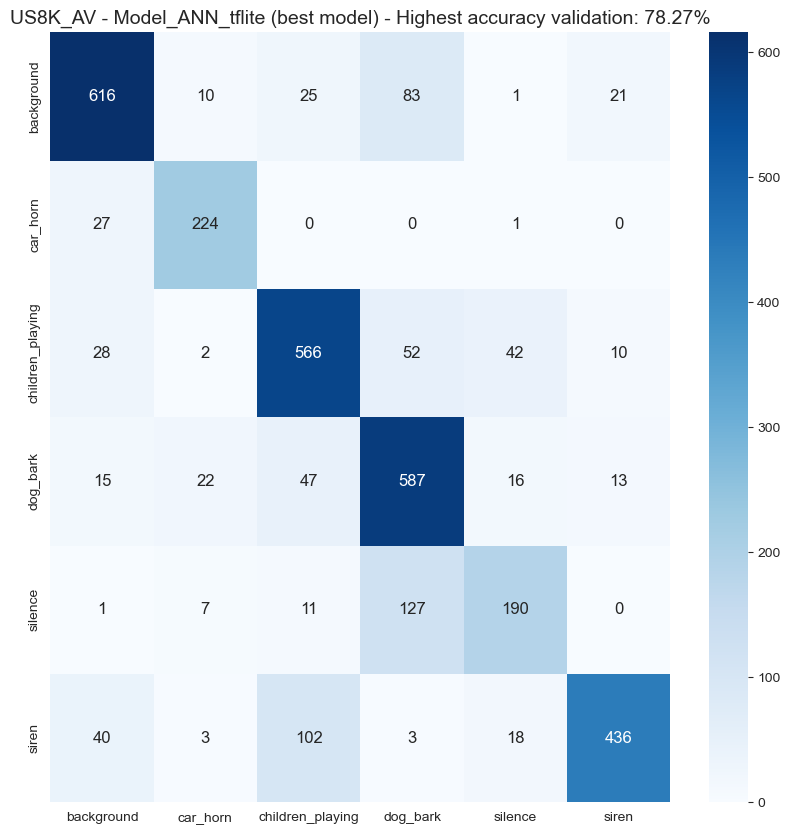

In [136]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_ANN, 
                      metrics_set_tflite_ANN['accuracy'], 
                      cmap_cm, 
                      'Model_ANN_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Inference CNN 1D

In [137]:
input_details_CNN1D[0]['shape']

array([  1, 375,   1])

In [138]:
t = X_val_norm_tflite[0].reshape(1,-1,1).shape
t

(1, 375, 1)

In [139]:
interpreter_CNN1D.set_tensor(input_details_CNN1D[0]['index'], X_val_norm_tflite[0].reshape(1,-1,1))

In [140]:
interpreter_CNN1D.invoke()

In [141]:
prediction_tflite_CNN1D = np.argmax(interpreter_CNN1D.get_tensor(output_details_CNN1D[0]['index']), axis=1)
prediction_tflite_CNN1D

array([3], dtype=int64)

In [142]:
predictions_tflite_CNN1D= []

for sample in X_val_norm_tflite:
    interpreter_CNN1D.set_tensor(input_details_CNN1D[0]['index'], sample.reshape(1,-1,1))
    interpreter_CNN1D.invoke()
    prediction_sample_CNN1D = np.argmax(interpreter_CNN1D.get_tensor(output_details_CNN1D[0]['index']), axis=1)
    predictions_tflite_CNN1D.append(prediction_sample_CNN1D[0])

predictions_tflite_CNN1D = np.array(predictions_tflite_CNN1D)

In [143]:
predictions_tflite_CNN1D

array([3, 3, 3, ..., 5, 0, 0], dtype=int64)

In [144]:
#predictions_tflite_CNN1D.tofile(os.path.join(path_arrays, '_saved_predict_val_CNN1D_tflite.csv'), sep=',')

In [145]:
y_pred_CNN_1D_saved

array([3, 3, 3, ..., 5, 0, 0], dtype=int64)

In [146]:
# Accuracy is the SAME, but with differences among the classes

np.array_equal(predictions_tflite_CNN1D, y_pred_CNN_1D_saved)

False

In [147]:
metrics_set_tflite_CNN1D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN1D, 
                                                 target_names=nom_classes,
                                                 output_dict=False)
print(metrics_set_tflite_CNN1D)

                  precision    recall  f1-score   support

      background       0.86      0.78      0.82       756
        car_horn       0.84      0.93      0.88       252
children_playing       0.68      0.78      0.73       700
        dog_bark       0.70      0.83      0.76       700
         silence       0.70      0.52      0.60       336
           siren       0.89      0.75      0.81       602

        accuracy                           0.77      3346
       macro avg       0.78      0.77      0.77      3346
    weighted avg       0.78      0.77      0.77      3346



In [148]:
metrics_set_tflite_CNN1D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN1D, 
                                                 target_names=nom_classes,
                                                 output_dict=True)
print(metrics_set_tflite_CNN1D['accuracy'])

0.7707710699342498


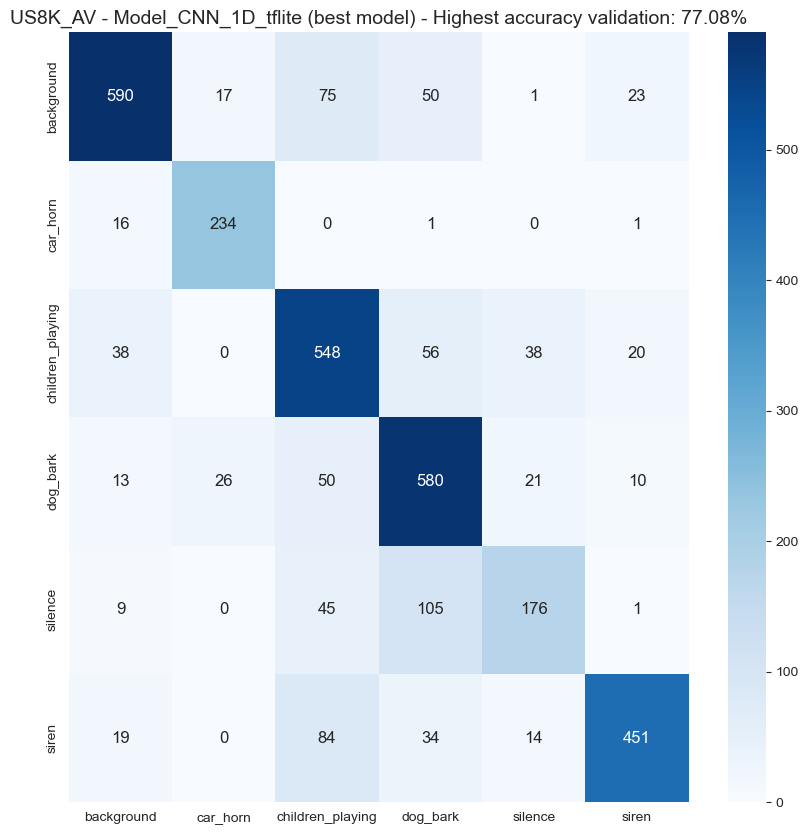

In [149]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN1D, 
                      metrics_set_tflite_CNN1D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_1D_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Inference CNN 2D

In [150]:
input_details_CNN2D[0]['shape']

array([  1, 180,  44,   1])

In [151]:
type(X_val_CNN2D[0][0][0][0])

numpy.float32

In [152]:
X_val_CNN2D[0].shape

(180, 44, 1)

In [153]:
t = X_val_CNN2D[0].reshape(1,-1,44,1)
t.shape

(1, 180, 44, 1)

In [154]:
interpreter_CNN2D.set_tensor(input_details_CNN2D[0]['index'], X_val_CNN2D[0].reshape(1,-1,44,1))

In [155]:
interpreter_CNN2D.invoke()

In [156]:
prediction_tflite_CNN2D = np.argmax(interpreter_CNN2D.get_tensor(output_details_CNN2D[0]['index']), axis=1)
prediction_tflite_CNN2D

array([3], dtype=int64)

In [157]:
predictions_tflite_CNN2D= []

for sample in X_val_CNN2D:
    interpreter_CNN2D.set_tensor(input_details_CNN2D[0]['index'], sample.reshape(1,-1,44,1))
    interpreter_CNN2D.invoke()
    prediction_sample_CNN2D = np.argmax(interpreter_CNN2D.get_tensor(output_details_CNN2D[0]['index']), axis=1)
    predictions_tflite_CNN2D.append(prediction_sample_CNN2D[0])

predictions_tflite_CNN2D = np.array(predictions_tflite_CNN2D)

In [158]:
predictions_tflite_CNN2D

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [159]:
predictions_tflite_CNN2D.tofile(os.path.join(path_arrays, '_saved_predict_val_CNN2D_tflite.csv'), sep=',')

In [160]:
y_pred_CNN_2D_saved 

array([3, 3, 3, ..., 1, 1, 1], dtype=int64)

In [161]:
# Accuracy DECREASED a little compared to the original model(81.71%)

np.array_equal(y_pred_CNN_2D_saved, predictions_tflite_CNN2D)

False

In [162]:
metrics_set_tflite_CNN2D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN2D, 
                                                 target_names=nom_classes,
                                                 output_dict=False)
print(metrics_set_tflite_CNN2D)

                  precision    recall  f1-score   support

      background       0.83      0.78      0.80       756
        car_horn       0.84      0.81      0.82       252
children_playing       0.72      0.81      0.76       700
        dog_bark       0.80      0.79      0.80       700
         silence       0.76      0.91      0.83       336
           siren       0.94      0.79      0.86       602

        accuracy                           0.81      3346
       macro avg       0.81      0.82      0.81      3346
    weighted avg       0.81      0.81      0.81      3346



In [163]:
metrics_set_tflite_CNN2D = classification_report(y_test_enc, 
                                                 predictions_tflite_CNN2D, 
                                                 target_names=nom_classes,
                                                 output_dict=True)
print(metrics_set_tflite_CNN2D['accuracy'])

0.8057381948595338


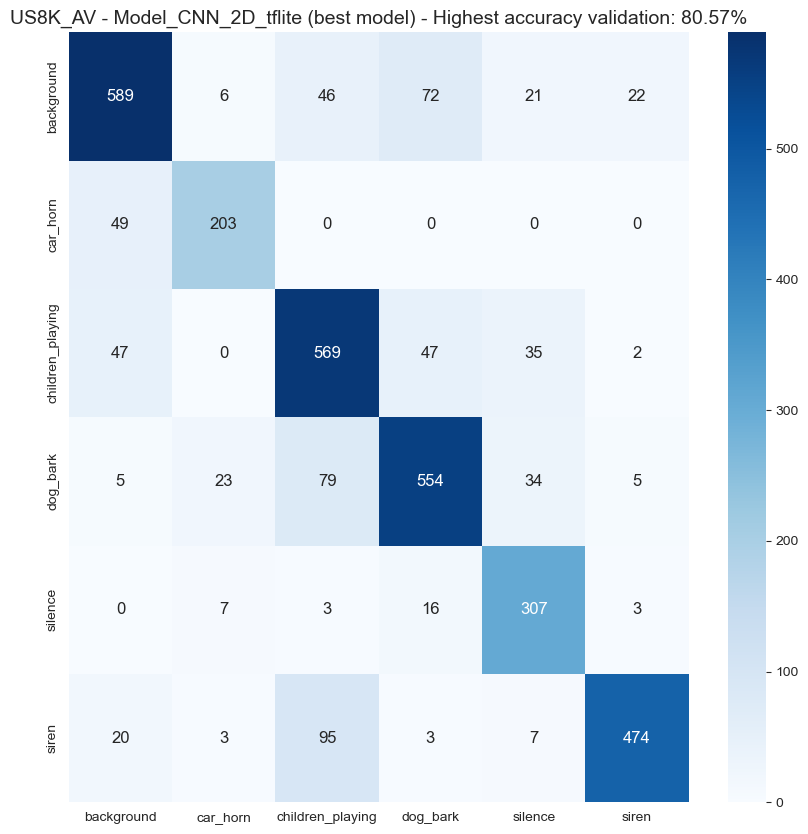

In [164]:
plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN2D, 
                      metrics_set_tflite_CNN2D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_2D_tflite_confusion_matrix',
                      ax = None,
                      savepic = True)

### Neural network models - Comparison between the decision matrices original x quantization

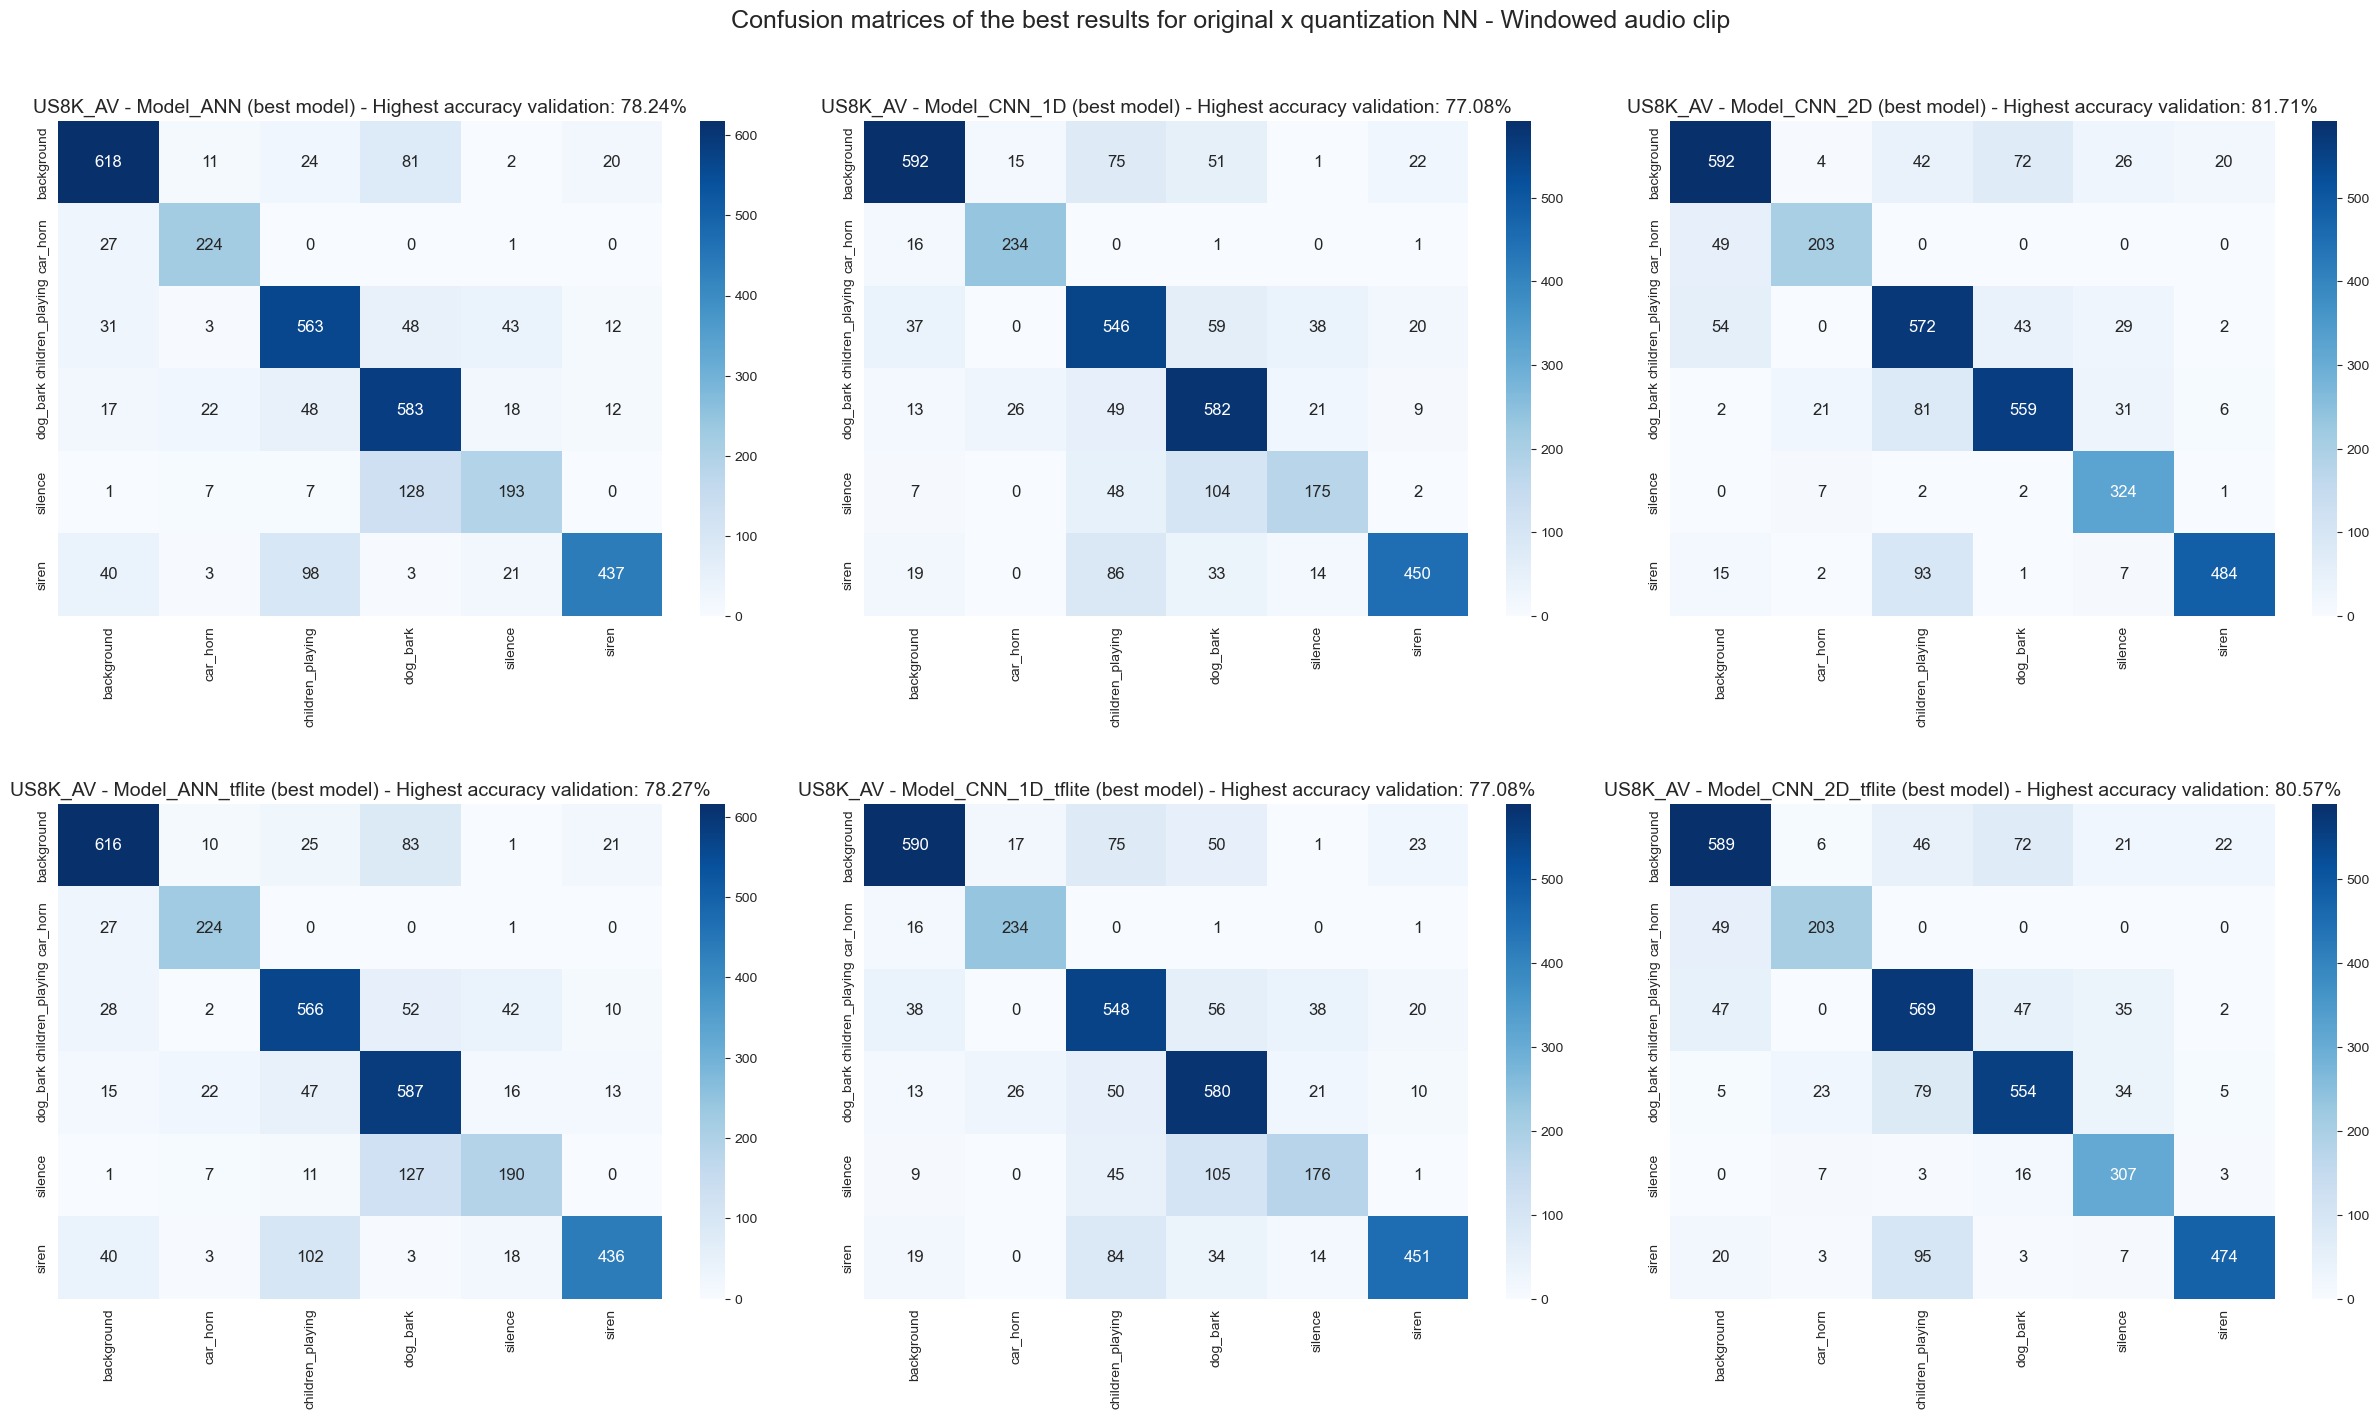

In [165]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, axs = plt.subplots(2, 3, figsize=(25,15))
plt.suptitle('Confusion matrices of the best results for original x quantization NN - Windowed audio clip', fontsize = 18,  y=0.97)


plot_confusion_matrix(y_test_enc, 
                      y_pred_ANN_saved, 
                      score_ANN_saved, 
                      cmap_cm, 
                      'Model_ANN_confusion_matrix',
                      ax=axs[0,0],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_1D_saved, 
                      score_CNN_1D_saved, 
                      cmap_cm, 
                      'Model_CNN_1D_confusion_matrix',
                      ax=axs[0,1],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      y_pred_CNN_2D_saved, 
                      score_CNN_2D_saved, 
                      cmap_cm, 
                      'Model_CNN_2D_confusion_matrix',
                      ax=axs[0,2],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_ANN, 
                      metrics_set_tflite_ANN['accuracy'], 
                      cmap_cm, 
                      'Model_ANN_tflite_confusion_matrix',
                      ax=axs[1,0],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN1D, 
                      metrics_set_tflite_CNN1D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_1D_tflite_confusion_matrix',
                      ax=axs[1,1],
                      savepic = False)

plot_confusion_matrix(y_test_enc, 
                      predictions_tflite_CNN2D, 
                      metrics_set_tflite_CNN2D['accuracy'], 
                      cmap_cm, 
                      'Model_CNN_2D_tflite_confusion_matrix',
                      ax=axs[1,2],
                      savepic = False)

plt.tight_layout(pad=4)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

# End of the notebook